In [1]:
#Import necessary libraries. Make sure to pip install missing ones.
import pandas as pd
import numpy as np
from numpy import nan
import pandas as pd
import re
from docx import Document
import docx
import time
from pymed import PubMed
from Bio import Entrez
import concurrent.futures
import random
from pubmed_lookup import PubMedLookup, Publication
import scispacy
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from docx.shared import Inches
from PIL import Image
import requests
import json
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


# Bioontology API Usage

1. Import necessary modules:
   - `urllib.request`, `urllib.error`, `urllib.parse`
   - `json`, `os`, `pprint`

2. Set up API configuration:
   - `REST_URL = "http://data.bioontology.org"`
   - `API_KEY = "d9885f69-dfed-44cd-81c3-f0591df67a03"`

3. Define `get_json` function:
   - Sends an HTTP request to a URL with the API key as the Authorization header.
   - Retrieves and parses the JSON response.

4. Get available resources:
   - Call `get_json` with the REST URL to retrieve resources.

5. Get ontologies:
   - Extract "ontologies" link from resources response.
   - Call `get_json` with ontologies URL to retrieve ontologies list.

6. Prepare ontology information for output:
   - Create empty list `ontology_output` for name and ID pairs.
   - Iterate ontologies list, append name and ID to `ontology_output`.

7. Print details of the first ontology:
   - Use `pprint` to print details of the first ontology.

8. Print names and IDs of all ontologies:
   - Iterate `ontology_output` and print each name and ID.

Note: Ensure valid API key, installed modules, and imported dependencies.


In [ ]:
# import urllib.request, urllib.error, urllib.parse
# import json
# import os
# from pprint import pprint

# REST_URL = "http://data.bioontology.org"
# API_KEY = "d9885f69-dfed-44cd-81c3-f0591df67a03"


# def get_json(url):
#     opener = urllib.request.build_opener()
#     opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
#     return json.loads(opener.open(url).read())

# # Get the available resources
# resources = get_json(REST_URL + "/")

# # Get the ontologies from the `ontologies` link
# ontologies = get_json(resources["links"]["ontologies"])

# # Get the name and ontology id from the returned list
# ontology_output = []
# for ontology in ontologies:
#     ontology_output.append(f"{ontology['name']}\n{ontology['@id']}\n")

# # Print the first ontology in the list
# pprint(ontologies[0])

# # Print the names and ids
# print("\n\n")
# for ont in ontology_output:
#     print(ont)

# Main Code
* Refer to: http://data.bioontology.org/documentation#nav_prop_search
* bioontology.org/wiki/BioPortal_Help#Programming_with_the_BioPortal_API

# Parsing Word Document Tables into a DataFrame

The code snippet below is designed to read a Microsoft Word (`.docx`) document that contains a table, and parse this table into a pandas DataFrame for further manipulation and analysis.

The document under consideration (`output_text.docx`) contains a table where first row is gene lists and the second row is the correspondng article abstract which the genes appear. Each gene's names and corresponding information are located in alternating rows of the same column.

The code reads this Word document using the `python-docx` library, parses the table, and places the extracted gene names and their corresponding information into separate lists. These lists are then used to construct a DataFrame, where each row corresponds to a gene and contains its name and associated information.


In [7]:
# Convert docx file to dataframe
import pandas as pd
import docx

doc = docx.Document('output_text.docx')
table = doc.tables[0]

# Initialize empty lists for gene and info
gene_list = []
info_list = []

for i, row in enumerate(table.rows):
    if i % 2 == 0:
        gene_list.append(row.cells[0].text)
    else:
        info_list.append(row.cells[0].text)

df = pd.DataFrame({'gene': gene_list, 'info': info_list})



In [8]:
df.shape

(692, 2)

# Bioontology Functions

## `find_pref_labels(api_key, url, text)`

- Parameters:
  - `api_key`: API key for authentication
  - `url`: URL for making API requests
  - `text`: Text to be analyzed

- Purpose: Finds preferred labels related to a given text using the Bioontology API.

- Steps:
  1. Set up parameters with API key, text, and specific ontology (DOID).
  2. Make an API request to retrieve annotations.
  3. Extract class details and labels from the response.
  4. Filter out specific class IDs.
  5. Make additional API requests to obtain class data and preferred labels.
  6. Return the list of preferred labels.

---

## `find_pref_labels2(api_key, url, text)`

- Parameters:
  - `api_key`: API key for authentication
  - `url`: URL for making API requests
  - `text`: Text to be analyzed

- Purpose: Finds preferred labels related to a given text using the Bioontology API, including custom keywords.

- Steps:
  1. Set up parameters with API key, text, and specific ontology (GO).
  2. Define custom keywords related to the analysis.
  3. Make an API request to retrieve annotations.
  4. Extract class details and labels from the response.
  5. Make additional API requests to obtain class data and preferred labels.
  6. Add custom keywords to the list of preferred labels if present in the text.
  7. Return the list of preferred labels.

---

## `extract_text_after_title(text)`

- Parameters:
  - `text`: Text to be processed

- Purpose: Extracts text after the keyword "Title:" in the given text.

- Steps:
  1. Split the text based on the keyword "Title:".
  2. Check if the keyword is present and there is text after it.
  3. Return the extracted text after removing leading and trailing whitespaces.

Note: The functions utilize the requests library and require valid API credentials.


In [9]:
def find_pref_labels(api_key, url, text):
    params = {
        "apikey": api_key,
        "text": text,        
        "ontologies": "DOID",
    }

    response = requests.get(url, params=params)


    annotations = json.loads(response.text)
    pref_labels = []
    for annotation in annotations:
        class_details = annotation["annotatedClass"]
        class_id = class_details["@id"]
        class_label = class_details["links"]["self"]

        if "DOID" in class_id and "DOID_4" not in class_id and "DOID_225" not in class_id:
            time.sleep(0.2) 
            class_response = requests.get(class_label, headers={"Authorization": f"apikey token={api_key}"})
            class_data = json.loads(class_response.text)
            pref_label = class_data.get("prefLabel", "N/A")
            pref_labels.append(pref_label)
    
    return pref_labels

def find_pref_labels2(api_key, url, text):
    # Use the Gene Ontology (GO) to detect keywords mentioned in the text
    params = {
        "apikey": api_key,
        "text": text,    
        "ontologies": "GO",
    }
    
    keywords = {'positive regulation of cell differentiation', 'cell fate specification', 'axonogenesis', 
                'forebrain generation of neurons', 'neuron development', 'negative regulation of cell differentiation', 
                'regulation of nervous system development', 'central nervous system development', 'brain development', 
                'forebrain development', 'embryonic organ development', 'neuron fate commitment', 
                'central nervous system neuron differentiation', 'negative regulation of developmental process', 
                'head development', 'neuron fate determination', 'cell fate commitment', 'neuron migration',
                'tube development'}
    response = requests.get(url, params=params)
    annotations = json.loads(response.text)
    pref_labels = []
    
    for annotation in annotations:
        class_details = annotation["annotatedClass"]
        class_id = class_details["@id"]
        class_label = class_details["links"]["self"]
        class_response = requests.get(class_label, headers={"Authorization": f"apikey token={api_key}"})
        class_data = json.loads(class_response.text)
        pref_label = class_data.get("prefLabel", "N/A")
        if pref_label not in pref_labels:
            pref_labels.append(pref_label)
    
    for keyword in keywords:
        if keyword in text and keyword not in pref_labels:
            pref_labels.append(keyword)
    
    return pref_labels

def extract_text_after_title(text):
    # Split the text based on the keyword "Title:"
    parts = text.split("Title:")

    # Check if the keyword "Title:" is present in the text and there's text after it
    if len(parts) > 1:
        # Return the text after "Title:" by removing leading and trailing whitespaces
        return parts[1].strip()
    else:
        # If the keyword "Title:" is not present in the text, return an empty string or a custom message
        return ""

# From dataframe to total disease frequencieis

## Bioontology API Usage

1. Set up API credentials:
   - `api_key = "d9885f69-dfed-44cd-81c3-f0591df67a03"`
   - `url = "https://data.bioontology.org/annotator"`

2. Iterate through the dataframe and extract text:
   - For each row, extract the text after the title in the 'info' column.

3. Find preferred labels using the Bioontology API:
   - Pass the extracted text to the `find_pref_labels` function, along with the API key and URL.
   - Receive a list of preferred labels as a result.

4. Count and store the preferred labels:
   - Iterate through the preferred labels obtained.
   - If the label already exists in the `temp` dictionary, increment its count.
   - If the label is new, add it to the `temp` dictionary with a count of 1.

Note: Ensure that the necessary functions (`extract_text_after_title` and `find_pref_labels`) are defined and imported in your code.


In [10]:
api_key = "d9885f69-dfed-44cd-81c3-f0591df67a03"
url = "https://data.bioontology.org/annotator"

temp = {}

for index, row in df.iterrows():
    text = extract_text_after_title(row['info'])

    pref_labels = find_pref_labels(api_key, url, text)
    print(pref_labels)
    for label in pref_labels:
        if label in temp:
            temp[label] += 1
        else:
            temp[label] = 1



['autistic disorder']
['autism spectrum disorder', 'autistic disorder', 'intellectual disability']
['autistic disorder', 'Fanconi anemia complementation group E']
['autistic disorder', 'intellectual disability', 'tauopathy']
['autistic disorder']
['tauopathy', "Alzheimer's disease", "Parkinson's disease", 'schizophrenia', 'autistic disorder', 'mild cognitive impairment', 'progressive supranuclear palsy']
['autistic disorder']
['autism spectrum disorder', 'autistic disorder']
['tauopathy', 'autism spectrum disorder', 'autistic disorder', 'intellectual disability', "Alzheimer's disease"]
[]
['autistic disorder', 'anxiety disorder']
['intellectual disability', 'autism spectrum disorder', 'autistic disorder']
['autistic disorder', 'intellectual disability', "Alzheimer's disease", 'tauopathy']
['autistic disorder', 'anxiety disorder']
['autistic disorder', 'intellectual disability', 'autism spectrum disorder']
['autistic disorder', "Alzheimer's disease", 'schizophrenia']
['autistic disorder

['autistic disorder']
['autistic disorder', 'toxic encephalopathy']
['autistic disorder', 'toxic encephalopathy']
['autistic disorder', 'anxiety disorder']
['autistic disorder', 'autism spectrum disorder']
['autistic disorder']
['autistic disorder', 'toxic encephalopathy']
['autistic disorder', 'anxiety disorder']
[]
['intellectual disability', 'autism spectrum disorder', 'autistic disorder']
['anxiety disorder', 'intellectual disability', 'autism spectrum disorder', 'autistic disorder']
['depressive disorder', "Alzheimer's disease", 'schizophrenia', 'autistic disorder', 'intellectual disability', 'Down syndrome', 'fragile X syndrome', 'Rett syndrome']
['autism spectrum disorder', 'autistic disorder', 'intellectual disability']
['autism spectrum disorder', 'autistic disorder']
['autistic disorder', 'autism spectrum disorder']
['autistic disorder', 'intellectual disability', 'autism spectrum disorder']
['intellectual disability', 'autistic disorder', 'anxiety disorder', 'non-syndromic i

['epilepsy', 'intellectual disability', 'autistic disorder', 'schizophrenia', 'Rett syndrome']
['autistic disorder', 'schizophrenia']
['blindness', 'Rett syndrome']
['autistic disorder', 'autism spectrum disorder']
['microcephaly', 'intellectual disability', 'obsolete dyskinetic syndrome', 'Rett syndrome', 'autistic disorder', 'epilepsy']
['anxiety disorder', 'autistic disorder']
['autism spectrum disorder', 'autistic disorder', 'fragile X syndrome']
['intellectual disability-severe speech delay-mild dysmorphism syndrome', 'intellectual disability', 'autistic disorder', 'optic atrophy 1']
['autism spectrum disorder', 'autistic disorder', 'intellectual disability-severe speech delay-mild dysmorphism syndrome', 'intellectual disability', 'optic atrophy 1']
['attention deficit hyperactivity disorder', 'autism spectrum disorder', 'autistic disorder', 'anxiety disorder']
['autistic disorder']
['intellectual disability-severe speech delay-mild dysmorphism syndrome', 'intellectual disability'

['Rett syndrome', 'autistic disorder', 'schizophrenia', 'anxiety disorder']
['Rett syndrome', 'autistic disorder', 'schizophrenia']
['schizophrenia', 'autistic disorder']
['intellectual disability', 'autistic disorder']
['syndromic X-linked intellectual disability Lubs type', 'autistic disorder']
['autism spectrum disorder', 'autistic disorder', 'Rett syndrome']
['Rett syndrome', 'syndromic X-linked intellectual disability Lubs type', 'Miller-Dieker lissencephaly syndrome', 'autistic disorder']
['autism spectrum disorder', 'autistic disorder']
['syndromic X-linked intellectual disability Lubs type', 'Miller-Dieker lissencephaly syndrome', 'autistic disorder']
['autistic disorder']
['autistic disorder', 'schizophrenia']
['autism spectrum disorder', 'autistic disorder']
['autistic disorder', 'schizophrenia', 'schizophrenia 1']
['autism spectrum disorder', 'autistic disorder', 'Rett syndrome']
['syndromic X-linked intellectual disability Lubs type', 'autistic disorder']
['attention defici

['Rett syndrome', 'autistic disorder', 'toxic encephalopathy']
['Rett syndrome', 'intellectual disability', 'anxiety disorder', 'autistic disorder']
['Rett syndrome', 'autistic disorder', 'Fanconi anemia complementation group E']
['Rett syndrome', 'autistic disorder']
['Rett syndrome', 'intellectual disability']
['Rett syndrome', 'autism spectrum disorder', 'autistic disorder']
['Rett syndrome', 'intellectual disability', 'autistic disorder']
['Rett syndrome', 'autism spectrum disorder', 'autistic disorder', 'intellectual disability']
['Rett syndrome', 'autistic disorder']
['autistic disorder', 'fragile X syndrome', 'intellectual disability']
['Rett syndrome', 'autism spectrum disorder', 'autistic disorder']
['autism spectrum disorder', 'autistic disorder', 'Rett syndrome']
['Rett syndrome', 'autistic disorder', 'intellectual disability', 'anxiety disorder']
['Rett syndrome', 'intellectual disability', 'autism spectrum disorder', 'autistic disorder', 'scoliosis']
['fragile X syndrome',

['Pitt-Hopkins syndrome', 'autistic disorder', 'intellectual disability']
['intellectual disability', 'Pitt-Hopkins syndrome', 'autistic disorder', 'schizophrenia']
['Pitt-Hopkins syndrome', 'autism spectrum disorder', 'autistic disorder']
['non-syndromic intellectual disability', 'syndromic intellectual disability', 'intellectual disability', 'schizophrenia', 'Pitt-Hopkins syndrome']
['autistic disorder']
['autistic disorder', 'schizophrenia', 'Pitt-Hopkins syndrome']
['intellectual disability', 'schizophrenia', 'autistic disorder']
['schizophrenia', 'Pitt-Hopkins syndrome', 'intellectual disability', 'autism spectrum disorder', 'autistic disorder']
['Pitt-Hopkins syndrome', 'intellectual disability', 'autism spectrum disorder', 'autistic disorder', 'myopia', 'epilepsy']
['schizophrenia', 'autistic disorder', 'intellectual disability', 'Pitt-Hopkins syndrome', 'autism spectrum disorder']
['Pitt-Hopkins syndrome', 'schizophrenia', 'microcephaly', 'anxiety disorder']
['autism spectrum d

# Capitalizing and Sorting Dictionaries

1. Create an empty dictionary `capitalized_dict`.

2. Iterate over the keys of the `temp` dictionary:
   - Capitalize each word in the key by splitting it, capitalizing each word, and joining them back.
   - Add the capitalized key and its corresponding value to `capitalized_dict`.

3. Print the `temp` dictionary in sorted order:
   - Sort `capitalized_dict` by values in descending order.
   - Print the sorted dictionary.

4. Filter the sorted dictionary:
   - Create a new dictionary `new_dict` by excluding key-value pairs with a value of 1.
   - Sort `new_dict` by values in descending order.
   - Print the filtered dictionary.

5. Further filtering:
   - Create `new_dict1` by selecting key-value pairs from `new_dict` where the value is greater than 5.
   - Create `new_dict2` by selecting key-value pairs from `new_dict` where the value is less than or equal to 5.
   - Print `new_dict1` and `new_dict2`.

Note: Ensure that the `temp` dictionary is defined and populated before executing this code.


In [33]:
capitalized_dict = {}

# Iterate over the keys of new_dict and capitalize each word
for key in temp.keys():
    new_key = ' '.join([word.title() for word in key.split()])
    capitalized_dict[new_key] = temp[key]
    
# Print the temp dictionary
sorted_dict = dict(sorted(capitalized_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)
print("=================================================")
new_dict = {key: value for key, value in sorted_dict.items() if value != 1}
new_dict = dict(sorted(new_dict.items(), key=lambda item: item[1], reverse=True))
print(new_dict)

print("=================================================")

new_dict1 = {key: value for key, value in new_dict.items() if value > 5}
new_dict2 = {key: value for key, value in new_dict.items() if value <= 5}
print(new_dict1)

{'Autistic Disorder': 649, 'Autism Spectrum Disorder': 266, 'Intellectual Disability': 192, 'Rett Syndrome': 148, 'Schizophrenia': 96, 'Anxiety Disorder': 61, 'Epilepsy': 49, 'Attention Deficit Hyperactivity Disorder': 20, "Alzheimer'S Disease": 18, 'Syndromic X-Linked Intellectual Disability Lubs Type': 17, 'Depressive Disorder': 16, 'Microcephaly': 16, 'Pitt-Hopkins Syndrome': 14, 'Fragile X Syndrome': 13, 'Neuroblastoma': 11, 'Brain Disease': 11, 'Bipolar Disorder': 10, 'Angelman Syndrome': 8, 'Tauopathy': 7, "Parkinson'S Disease": 6, 'West Syndrome': 6, 'Toxic Encephalopathy': 6, 'Obesity': 6, 'Allergic Disease': 6, 'Obsessive-Compulsive Disorder': 6, 'Dementia': 5, 'Lissencephaly': 5, 'Down Syndrome': 5, 'Charge Syndrome': 5, 'Multiple Sclerosis': 5, 'Intellectual Disability-Severe Speech Delay-Mild Dysmorphism Syndrome': 5, 'Polymicrogyria': 4, 'Dystonia': 4, 'Syndromic Intellectual Disability': 4, 'Williams-Beuren Syndrome': 4, 'Prader-Willi Syndrome': 4, 'Fanconi Anemia Complem

In [47]:
len(new_dict2)

45

## Disease Counts Bar Plot

### Disease Counts Distribution Plot

1. Import the `matplotlib.pyplot` module as `plt`.

2. Define the thresholds for categorizing the values: `[100, 50, 10]`.

3. Initialize the counters for each category: `[0, 0, 0, 0]`.

4. Iterate over the values in the `new_dict` dictionary:
   - Compare each value with the thresholds and increment the corresponding counter.

5. Create a bar plot of the counts:
   - Create a figure and axis object using `plt.subplots()`.
   - Use `plt.bar()` to create a bar plot with labels ['>100', '50-100', '10-50', '<10'] and the counts.
   - Set the title, xlabel, and ylabel for the plot.
   - Adjust the layout using `plt.tight_layout()`.

6. Add text to the plot:
   - Use `plt.text()` to add the text 'N = 70' at coordinates (0.05, 0.95) relative to the axes.
   - Customize the fontsize, verticalalignment, and bbox properties.

7. Save the plot as 'plot2.png' with a dpi of 300.

8. Display the plot using `plt.show()`.

Note: Ensure that `new_dict` is defined and contains data before executing this code.


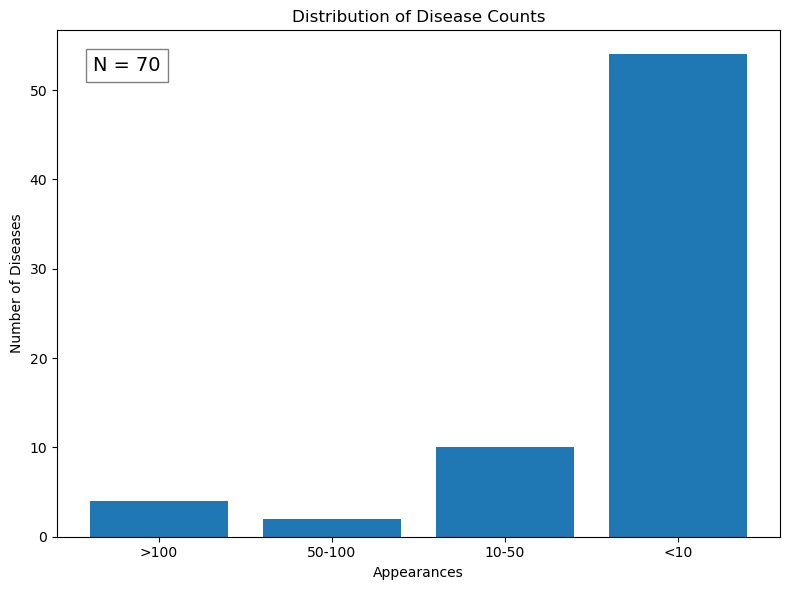

In [59]:
import matplotlib.pyplot as plt

# Define the thresholds
thresholds = [100, 50, 10]

# Initialize the counters
counts = [0, 0, 0, 0]

# Iterate over the values in the dictionary
for value in new_dict.values():
    if value > thresholds[0]:
        counts[0] += 1
    elif value > thresholds[1]:
        counts[1] += 1
    elif value > thresholds[2]:
        counts[2] += 1
    else:
        counts[3] += 1

# Create a bar plot of the counts
# Create a bar plot of the counts
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(['>100', '50-100', '10-50', '<10'], counts)
plt.title('Distribution of Disease Counts')
plt.xlabel('Appearances')
plt.ylabel('Number of Diseases')
plt.tight_layout()

# Add text to the plot
plt.text(0.05, 0.95, 'N = 70', transform=ax.transAxes, fontsize=14,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))

plt.savefig('plot2.png', dpi=300)
plt.show()



# New Dict1,2 Barplot

# Disease Frequency Bar Plot

1. Import the `matplotlib.pyplot` module as `plt`.

2. Define the data to be plotted:
   - `new_dict1`: A dictionary containing disease names as keys and their respective frequencies as values.

3. Extract the keys (disease names) and values (frequencies) from `new_dict1`:
   - Create a list of disease names: `disease_names = list(new_dict1.keys())`.
   - Create a list of frequencies: `frequencies = list(new_dict1.values())`.

4. Create the bar plot:
   - Create a figure with a size of (15, 6) using `plt.figure(figsize=(15, 6))`.
   - Use `plt.bar()` to create the bar plot with disease_names as the x-axis and frequencies as the y-axis.
   - Set the y-axis label to 'Frequency' using `plt.ylabel('Frequency')`.
   - Set the title of the plot to 'Disease Frequency' using `plt.title('Disease Frequency')`.
   - Rotate the x-axis labels for better readability using `plt.xticks(rotation=90)`.

5. Add text to the plot:
   - Use `plt.text()` to add the text 'N=25' at coordinates (0.95, 0.95) relative to the axes.
   - Customize the horizontalalignment, verticalalignment, fontsize, and bbox properties.

6. Display the plot using `plt.show()`.

Note: Ensure that `new_dict1` is defined and contains the relevant data before executing this code.



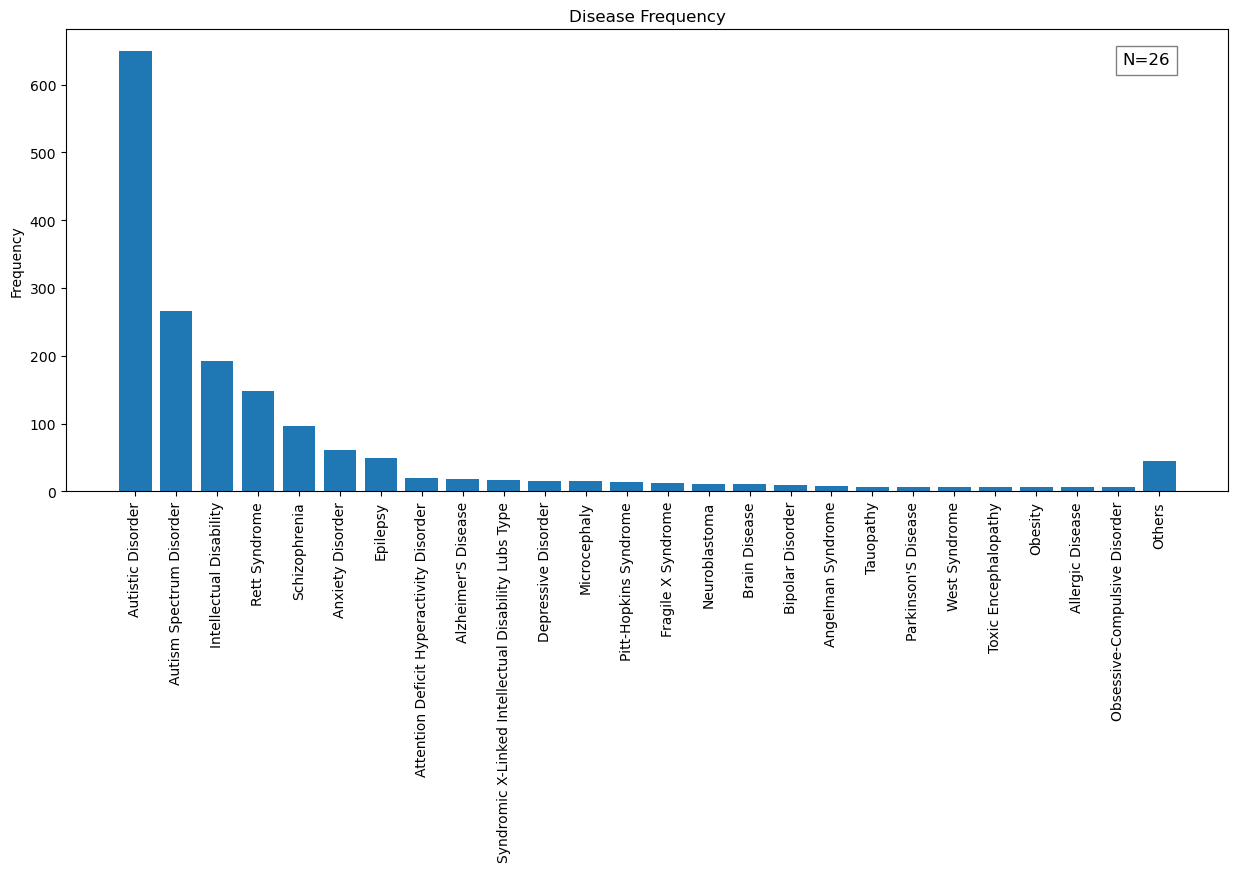

In [60]:
import matplotlib.pyplot as plt

# Data
new_dict1 = {'Autistic Disorder': 649, 'Autism Spectrum Disorder': 266, 'Intellectual Disability': 192, 'Rett Syndrome': 148, 'Schizophrenia': 96, 'Anxiety Disorder': 61, 'Epilepsy': 49, 'Attention Deficit Hyperactivity Disorder': 20, "Alzheimer'S Disease": 18, 'Syndromic X-Linked Intellectual Disability Lubs Type': 17, 'Depressive Disorder': 16, 'Microcephaly': 16, 'Pitt-Hopkins Syndrome': 14, 'Fragile X Syndrome': 13, 'Neuroblastoma': 11, 'Brain Disease': 11, 'Bipolar Disorder': 10, 'Angelman Syndrome': 8, 'Tauopathy': 7, "Parkinson'S Disease": 6, 'West Syndrome': 6, 'Toxic Encephalopathy': 6, 'Obesity': 6, 'Allergic Disease': 6, 'Obsessive-Compulsive Disorder': 6, 'Others': len(new_dict2)}

# Extract the keys (x-axis) and values (y-axis)
disease_names = list(new_dict1.keys())
frequencies = list(new_dict1.values())

# Create the bar plot
plt.figure(figsize=(15, 6))
plt.bar(disease_names, frequencies)
plt.ylabel('Frequency')
plt.title('Disease Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Add N=25 text on the top right of the plot
plt.text(0.95, 0.95, f'N={len(new_dict1)}', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', pad=5.0) )

# Show the plot
plt.show()

# Disease Frequency Bar Plot (Filtered)

1. Extract the keys (disease names) and values (frequencies) from `new_dict2`:
   - Create a list of disease names: `disease_names = list(new_dict2.keys())`.
   - Create a list of frequencies: `frequencies = list(new_dict2.values())`.

2. Create the bar plot:
   - Create a figure with a size of (13, 6) using `plt.figure(figsize=(13, 6))`.
   - Use `plt.bar()` to create the bar plot with disease_names as the x-axis and frequencies as the y-axis.
   - Set the y-axis label to 'Frequency' using `plt.ylabel('Frequency')`.
   - Set the title of the plot to 'Disease Frequency' using `plt.title('Disease Frequency')`.
   - Rotate the x-axis labels for better readability using `plt.xticks(rotation=90)`.

3. Add text to the plot:
   - Use `plt.text()` to add the text 'N=25' at coordinates (0.95, 0.95) relative to the axes.
   - Customize the horizontalalignment, verticalalignment, fontsize, and bbox properties.

4. Display the plot using `plt.show()`.

Note: Ensure that `new_dict2` is defined and contains the relevant data before executing this code.


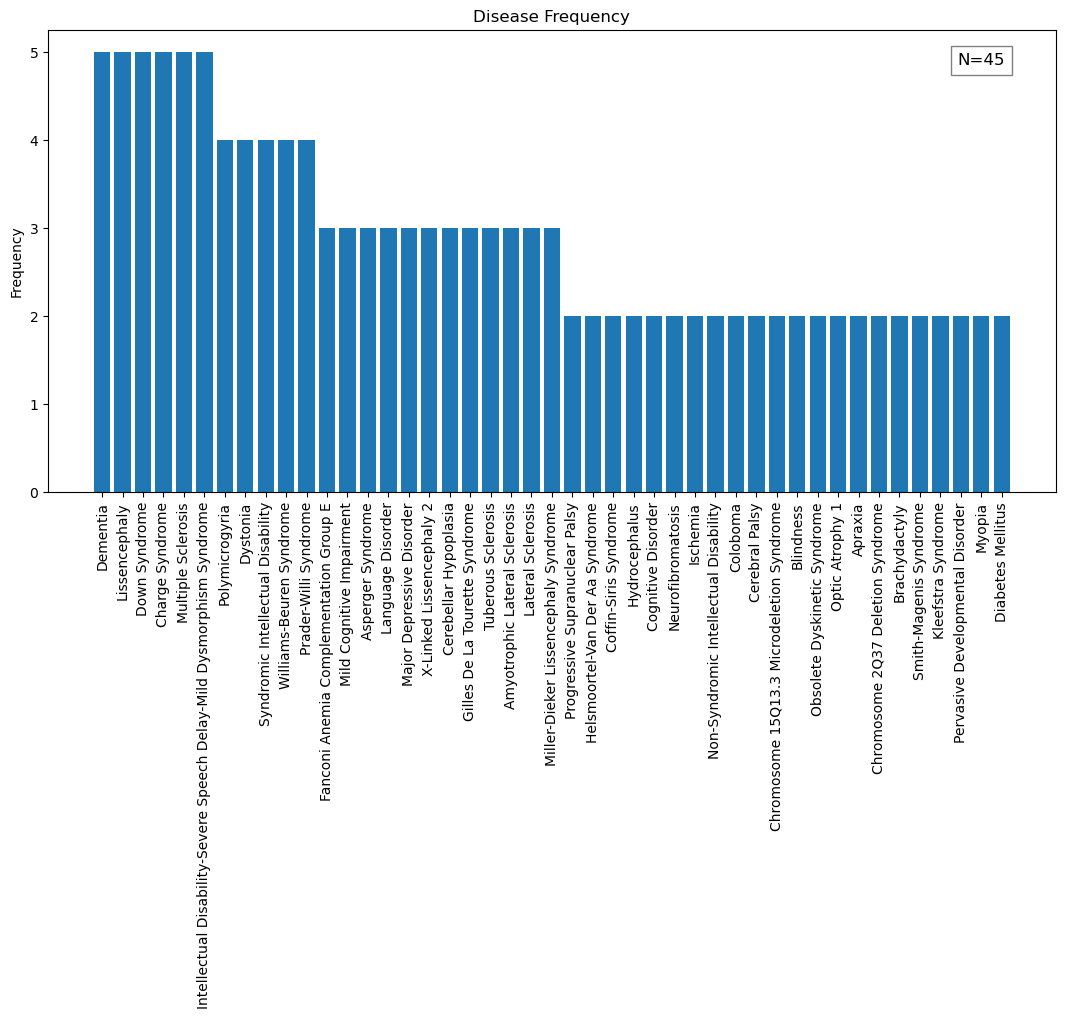

In [63]:
# Extract the keys (x-axis) and values (y-axis)
disease_names = list(new_dict2.keys())
frequencies = list(new_dict2.values())

# Create the bar plot
plt.figure(figsize=(13, 6))
plt.bar(disease_names, frequencies)
plt.ylabel('Frequency')
plt.title('Disease Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Add N=25 text on the top right of the plot
plt.text(0.95, 0.95, f'N={len(new_dict2)}', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', pad=5.0) )

# Show the plot
plt.show()


# DO Terms

# Heatmap (running the code below takes a long time)

# Disease-Gene Mapping

1. Define the API key and URL for the Bioontology annotator:
   - `api_key = "d9885f69-dfed-44cd-81c3-f0591df67a03"`
   - `url = "https://data.bioontology.org/annotator"`

2. Create an empty dictionary `disease_Gene` with tf keys:
   - Loop through the `tf` list and initialize an empty dictionary for each tf key in `disease_Gene`.

3. Loop through the DataFrame rows using `iterrows()`:
   - Extract the text after "Title:" from the 'info' column.
   - Convert the 'gene' value to a list called `temp_gene` by splitting on ', '.

4. Get the preferred labels for each text using the `find_pref_labels` function:
   - Pass the API key, URL, and text to the function.
   - Store the returned preferred labels in the `pref_labels` variable.
   - Add a small delay (0.1 seconds) using `time.sleep(0.1)`.

5. Update the `disease_Gene` dictionary based on the preferred labels and genes:
   - Iterate over each label in `pref_labels`.
   - Iterate over each gene in `temp_gene`.
   - Access the corresponding disease frequency dictionary for the gene from `disease_Gene`.
   - If the label already exists in the disease frequency dictionary, increment its count.
   - If the label is not present, add it to the dictionary with an initial count of 1.

6. Print the resulting `disease_Gene` dictionary.

Note: Ensure that the required functions (`extract_text_after_title`, `find_pref_labels`) are defined and available before executing this code. Also, ensure that the DataFrame `df` and the variables `tf` are defined and contain the necessary data.


In [69]:
api_key = "d9885f69-dfed-44cd-81c3-f0591df67a03"
url = "https://data.bioontology.org/annotator"
disease_Gene = {key: {} for key in tf}

# Loop through the DataFrame rows
for index, row in df.iterrows():
    # Extract the text after "Title:"
    text = extract_text_after_title(row['info'])

    # Convert row['gene'] to a list called temp_gene
    temp_gene = row['gene'].split(', ')

    # Get the preferred labels using the find_pref_labels function
    pref_labels = find_pref_labels(api_key, url, text)
    time.sleep(0.1)
    # Update the disease_Freq dictionaries for each tf key in temp_gene based on pref_labels
    for label in pref_labels:
        for gene in temp_gene:
            disease_Freq = disease_Gene[gene]

            if label in disease_Freq:
                disease_Freq[label] += 1
            else:
                disease_Freq[label] = 1

# Print the resulting disease_Gene dictionary
print("=========================================")
print(disease_Gene)

{'ADNP': {'autistic disorder': 29, 'autism spectrum disorder': 9, 'intellectual disability': 7, 'Fanconi anemia complementation group E': 1, 'tauopathy': 7, "Alzheimer's disease": 8, "Parkinson's disease": 1, 'schizophrenia': 6, 'mild cognitive impairment': 3, 'progressive supranuclear palsy': 2, 'anxiety disorder': 2, 'obsolete protein deficiency': 1, 'Helsmoortel-Van Der Aa Syndrome': 2, 'epilepsy': 1, 'imperforate anus': 1, 'neuroblastoma': 1}, 'AHDC1': {'autism spectrum disorder': 1, 'autistic disorder': 2, 'Xia-Gibbs Syndrome': 1, 'intellectual disability': 2, 'spastic quadriplegia': 1, 'quadriplegia': 1}, 'AKT3': {'epilepsy': 2, 'autistic disorder': 4, 'intellectual disability': 2, 'polymicrogyria': 2, 'autism spectrum disorder': 1, 'periventricular nodular heterotopia': 1}, 'Androgen Receptor': {'autistic disorder': 12, 'Asperger syndrome': 1, 'neuroblastoma': 2, 'intellectual disability': 3, 'autism spectrum disorder': 3, 'language disorder': 1, 'Klinefelter syndrome': 1, 'depr

# Filter and Sort Disease-Gene Mapping

1. Filter out key-value pairs in the `disease_Gene` dictionary where the frequency is 1:
   - Create a new dictionary `disease_Gene` using a dictionary comprehension.
   - Iterate over each gene and disease_dict in the original `disease_Gene`.
   - Filter the disease_dict based on the frequency (`freq`) of each disease, keeping only those with freq > 1.

2. Sort the nested dictionaries based on frequency in descending order:
   - Iterate over each gene and disease_dict in the updated `disease_Gene`.
   - Use `sorted()` with a lambda function to sort the items in the disease_dict by value (frequency) in descending order.
   - Assign the sorted dictionary back to the corresponding gene in the `disease_Gene`.

Note: Ensure that the `disease_Gene` dictionary is defined and contains the relevant data before executing this code.


In [71]:
# Delete key-value pairs where frequency is 1
disease_Gene = {gene: {disease: freq for disease, freq in disease_dict.items() if freq > 1}
                for gene, disease_dict in disease_Gene.items()}

# Sort the nested dictionary based on frequency in descending order
for gene, disease_dict in disease_Gene.items():
    disease_Gene[gene] = dict(sorted(disease_dict.items(), key=lambda item: item[1], reverse=True))

# Count Unique Disease Names

1. Create an empty set called `unique_diseases`.

2. Iterate over the `disease_Gene` dictionary:
   - For each gene, access the associated diseases dictionary.
   - Update the `unique_diseases` set by adding the keys (disease names) from the diseases dictionary.

3. Get the count of unique disease names:
   - Use the `len()` function to calculate the number of unique disease names in the `unique_diseases` set.

4. Print the count of unique disease names with a descriptive message.

Note: Ensure that the `disease_Gene` dictionary is defined and contains the relevant data before executing this code.


In [220]:
unique_diseases = set()
for gene, diseases in disease_Gene.items():
    unique_diseases.update(diseases.keys())

num_unique_diseases = len(unique_diseases)

print(f"There are {num_unique_diseases} unique disease names in the dictionary.")


There are 173 unique disease names in the dictionary.


# Filtered Disease-Gene Mapping

1. Create a new dictionary `ontology_Gene` by filtering out genes without associated diseases:
   - Iterate over each key-value pair (gene and diseases) in the `disease_Gene` dictionary.
   - Use a dictionary comprehension to keep only the key-value pairs where the value (diseases) is not empty.

2. Check the type of the `disease_Gene` dictionary:
   - Use the `type()` function to determine the type of the `disease_Gene` dictionary.

Note: The resulting `ontology_Gene` dictionary contains the filtered disease-gene mapping, while the type of `disease_Gene` is preserved as it was before the filtering operation.


In [61]:
ontology_Gene = {'ADNP': {'autistic disorder': 29, 'autism spectrum disorder': 9, 'intellectual disability': 7, 'Fanconi anemia complementation group E': 1, 'tauopathy': 7, "Alzheimer's disease": 8, "Parkinson's disease": 1, 'schizophrenia': 6, 'mild cognitive impairment': 3, 'progressive supranuclear palsy': 2, 'anxiety disorder': 2, 'obsolete protein deficiency': 1, 'Helsmoortel-Van Der Aa Syndrome': 2, 'epilepsy': 1, 'imperforate anus': 1, 'neuroblastoma': 1}, 'AHDC1': {'autism spectrum disorder': 1, 'autistic disorder': 2, 'Xia-Gibbs Syndrome': 1, 'intellectual disability': 2, 'spastic quadriplegia': 1, 'quadriplegia': 1}, 'AKT3': {'epilepsy': 2, 'autistic disorder': 4, 'intellectual disability': 2, 'polymicrogyria': 2, 'autism spectrum disorder': 1, 'periventricular nodular heterotopia': 1}, 'Androgen Receptor': {'autistic disorder': 12, 'Asperger syndrome': 1, 'neuroblastoma': 2, 'intellectual disability': 3, 'autism spectrum disorder': 3, 'language disorder': 1, 'Klinefelter syndrome': 1, 'depressive disorder': 1, 'anxiety disorder': 1}, 'ARID1B': {'autistic disorder': 18, 'intellectual disability': 9, 'autism spectrum disorder': 13, 'congenital heart disease': 1, 'heart disease': 1, 'anxiety disorder': 4, 'neuroblastoma': 1, 'Coffin-Siris syndrome': 2, 'hydrocephalus': 1}, 'ARID2': {}, 'ARNT2': {'schizophrenia': 2, 'autistic disorder': 2, 'dementia': 1}, 'ARNTL': {'autistic disorder': 2, 'anxiety disorder': 2, 'bipolar disorder': 1, 'depressive disorder': 1, 'schizophrenia': 1, "Alzheimer's disease": 1, 'major depressive disorder': 1}, 'ARX': {'autistic disorder': 16, 'epilepsy': 11, 'intellectual disability': 12, 'autism spectrum disorder': 3, 'lissencephaly': 5, 'microcephaly': 2, 'West syndrome': 5, 'X-linked lissencephaly 2': 3, 'schizophrenia': 2, 'anxiety disorder': 1, 'cognitive disorder': 1, 'dystonia': 3, 'corpus callosum agenesis-abnormal genitalia syndrome': 1, 'cerebellar hypoplasia': 1, 'Partington syndrome': 1}, 'ASH1L': {'autism spectrum disorder': 8, 'autistic disorder': 10, 'intellectual disability': 8, 'epilepsy': 3, 'schizophrenia': 1, 'brain disease': 1, 'bipolar disorder': 1, 'anxiety disorder': 2, 'Gilles de la Tourette syndrome': 1}, 'ATRX': {'intellectual disability': 2, 'autistic disorder': 4, 'autism spectrum disorder': 1, 'schizophrenia': 1, 'tuberous sclerosis': 1, 'neurofibromatosis': 1}, 'BAZ2B': {'autism spectrum disorder': 1, 'autistic disorder': 1}, 'BCL11A': {'autism spectrum disorder': 1, 'autistic disorder': 6, 'intellectual disability': 2, 'bipolar disorder': 1, 'thalassemia': 1, 'otopalatodigital syndrome type 1': 1, 'Rothmund-Thomson syndrome': 1, 'ischemia': 1, 'schizophrenia': 1, 'chromosome 2p16.1-p15 deletion syndrome': 1, 'microcephaly': 1}, 'BRD4': {}, 'BTAF1': {}, 'BTRC': {'autistic disorder': 1}, 'CAMK2A': {'autism spectrum disorder': 1, 'autistic disorder': 3, 'hydrocephalus': 1}, 'CARD11': {}, 'CASZ1': {}, 'Catalase': {'autistic disorder': 21, "Alzheimer's disease": 3, "Parkinson's disease": 1, 'dementia': 1, 'anxiety disorder': 9, 'toxic encephalopathy': 5, 'autism spectrum disorder': 5, 'attention deficit hyperactivity disorder': 1, 'fragile X syndrome': 1, 'propionic acidemia': 1, 'schizophrenia': 1, 'narcolepsy': 1}, 'CC2D1A': {'intellectual disability': 9, 'autism spectrum disorder': 9, 'autistic disorder': 11, 'anxiety disorder': 3, 'depressive disorder': 1, "Alzheimer's disease": 1, 'schizophrenia': 1, 'Down syndrome': 1, 'fragile X syndrome': 1, 'Rett syndrome': 1, 'non-syndromic intellectual disability': 1, 'syndromic intellectual disability': 1}, 'CHAMP1': {}, 'CHD1': {'epilepsy': 1, 'autism spectrum disorder': 1, 'autistic disorder': 1, 'intellectual disability': 1, 'brain disease': 1}, 'CHD2': {'autism spectrum disorder': 2, 'autistic disorder': 4, 'intellectual disability': 4, 'epilepsy': 2, 'schizophrenia': 1, 'brain disease': 2, 'bipolar disorder': 1, 'CHARGE syndrome': 1}, 'CHD3': {'intellectual disability': 1, 'autistic disorder': 1}, 'CHD7': {'epilepsy': 1, 'autism spectrum disorder': 4, 'autistic disorder': 9, 'intellectual disability': 4, 'brain disease': 1, 'CHARGE syndrome': 5, 'coloboma': 1}, 'CHD9': {}, 'CIC': {'autism spectrum disorder': 2, 'autistic disorder': 2, 'intellectual disability': 1, 'attention deficit hyperactivity disorder': 1}, 'CNOT3': {}, 'CREBBP': {'autism spectrum disorder': 3, 'autistic disorder': 4, 'intellectual disability': 2}, 'CSDE1': {'autistic disorder': 1, 'intellectual disability': 1}, 'CTCF': {'autistic disorder': 5, "Alzheimer's disease": 1, 'multiple sclerosis': 1, 'intellectual disability': 1, 'schizophrenia': 2}, 'CTNNB1': {'autistic disorder': 5, 'spastic diplegia': 1, 'intellectual disability': 1, 'bruxism': 1, 'schizophrenia': 1, 'bipolar disorder': 1, 'major depressive disorder': 1, 'depressive disorder': 1, 'attention deficit hyperactivity disorder': 1, 'autism spectrum disorder': 2, 'microcephaly': 1}, 'CUL3': {'autistic disorder': 7, 'autism spectrum disorder': 3, 'schizophrenia': 3, 'anxiety disorder': 1}, 'CUX1': {'intellectual disability': 1, 'autistic disorder': 5, 'autism spectrum disorder': 2}, 'CUX2': {'autistic disorder': 2, 'intellectual disability': 1, 'autism spectrum disorder': 1, 'brain disease': 1, 'epilepsy': 1}, 'DDX3X': {'autistic disorder': 6, 'autism spectrum disorder': 4, 'intellectual disability': 4, 'microcephaly': 1, 'hypothyroidism': 1, 'epilepsy': 1, 'polymicrogyria': 1, 'schizophrenia': 1}, 'DEAF1': {}, 'DLX2': {'autistic disorder': 3, 'schizophrenia': 1, 'intellectual disability': 1}, 'DLX3': {'Williams-Beuren syndrome': 1, 'autism spectrum disorder': 1, 'autistic disorder': 1}, 'DLX6': {'anxiety disorder': 1, 'Rett syndrome': 1, 'autistic disorder': 1}, 'DNMT3A': {'intellectual disability': 2, 'autistic disorder': 10, 'obesity': 1, 'Rett syndrome': 2, 'attention deficit hyperactivity disorder': 1, 'autism spectrum disorder': 2, 'West syndrome': 1, 'epilepsy': 1}, 'DVL3': {'genetic disease': 1, 'amyotrophic lateral sclerosis': 1, 'lateral sclerosis': 1, 'autism spectrum disorder': 1, 'autistic disorder': 2, 'Chediak-Higashi syndrome': 1, 'Charcot-Marie-Tooth disease': 1, 'tooth disease': 1, 'centronuclear myopathy': 1, 'dermatopathia pigmentosa reticularis': 1, 'frontotemporal dementia': 1, 'dementia': 1, 'infantile hypophosphatasia': 1, 'X-linked myopathy with excessive autophagy': 1, 'neurodegeneration with brain iron accumulation': 1, 'neuronal ceroid lipofuscinosis': 1, 'Niemann-Pick disease type C1': 1, 'Niemann-Pick disease': 1, "Pick's disease": 1, "Parkinson's disease": 1, 'neurodegeneration with brain iron accumulation 5': 1, 'alcohol-related neurodevelopmental disorder': 1, 'brain disease': 1, 'Warburg micro syndrome': 1}, 'EBF3': {'autistic disorder': 2, 'hypotonia, ataxia, and delayed development syndrome': 1, 'intellectual disability': 2}, 'EED': {}, 'EGR3': {'autism spectrum disorder': 1, 'autistic disorder': 1, 'respiratory syncytial virus infectious disease': 1}, 'EN2': {'autistic disorder': 42, 'schizophrenia': 4, 'intellectual disability': 5, 'autism spectrum disorder': 19, 'obesity': 1, 'allergic disease': 1, 'cerebral palsy': 1, 'epilepsy': 3, 'lissencephaly 1': 1, 'amelogenesis imperfecta type 1G': 1, 'cerebellar hypoplasia': 1, 'depressive disorder': 2, 'anxiety disorder': 1, 'fragile X syndrome': 1, 'rubella': 1}, 'EP300': {}, 'EP400': {}, 'ERBIN': {'autism spectrum disorder': 1, 'autistic disorder': 1}, 'ERG': {'autistic disorder': 3, 'chromosome 15q13.3 microdeletion syndrome': 1, 'intellectual disability': 1, 'epilepsy': 1, 'autism spectrum disorder': 2, 'schizophrenia': 2, 'seasonal affective disorder': 1}, 'ESR2': {'autism spectrum disorder': 1, 'autistic disorder': 1}, 'ESRRB': {}, 'EZH2': {'autism spectrum disorder': 3, 'autistic disorder': 4, 'anxiety disorder': 1, 'intellectual disability': 1}, 'FAN1': {'chromosome 15q13.3 microdeletion syndrome': 2, 'intellectual disability': 2, 'epilepsy': 2, 'autism spectrum disorder': 2, 'autistic disorder': 2, 'schizophrenia': 2}, 'FBN1': {}, 'FEZF2': {'autistic disorder': 3, 'autism spectrum disorder': 1, 'obsessive-compulsive disorder': 1, 'tic disorder': 1}, 'FOXG1': {'autistic disorder': 10, 'schizophrenia': 5, 'intellectual disability': 3, 'autism spectrum disorder': 3, 'Rett syndrome': 6, 'microcephaly': 2, 'epilepsy': 2, 'blindness': 1, 'obsolete dyskinetic syndrome': 1}, 'FOXP1': {'autistic disorder': 24, 'intellectual disability': 14, 'language disorder': 1, 'autism spectrum disorder': 11, 'anxiety disorder': 4, 'fragile X syndrome': 1, 'intellectual disability-severe speech delay-mild dysmorphism syndrome': 5, 'optic atrophy 1': 2, 'attention deficit hyperactivity disorder': 1, 'paranoid schizophrenia': 1, 'schizophrenia': 1, 'obsolete dyskinetic syndrome': 1, 'bipolar disorder': 1, 'achalasia': 1, 'muscular atrophy': 1, 'neuroblastoma': 1, 'ischemia': 1}, 'FOXP2': {'autistic disorder': 32, 'intellectual disability': 6, 'language disorder': 3, 'schizophrenia': 7, 'autism spectrum disorder': 9, 'fragile X syndrome': 1, 'attention deficit hyperactivity disorder': 2, 'antisocial personality disorder': 1, 'personality disorder': 1, 'apraxia': 2, 'speech disorder': 1, 'focal epilepsy': 1, 'epilepsy': 3, 'bipolar disorder': 1, 'speech-language disorder-1': 1, 'multiple sclerosis': 2, 'neuroblastoma': 1, 'Down syndrome': 1, 'ankyloglossia': 1, 'Lewy body dementia': 1, 'dementia': 1, 'amyotrophic lateral sclerosis': 1, 'lateral sclerosis': 1, 'cognitive disorder': 1, "Alzheimer's disease": 1, 'cerebral malaria': 1, 'malaria': 1, 'encephalitis': 1, 'anxiety disorder': 1, 'polymicrogyria': 1, 'influenza': 1, 'specific language impairment': 1}, 'GLIS1': {}, 'GPC3': {}, 'GTF2I': {'Williams-Beuren syndrome': 4, 'autism spectrum disorder': 4, 'autistic disorder': 5, 'fragile X syndrome': 1, 'intellectual disability': 1, 'allergic disease': 1, 'anxiety disorder': 1}, 'HDAC4': {'intellectual disability': 3, 'epilepsy': 1, 'autistic disorder': 3, 'microcephaly': 1, 'chromosome 2q37 deletion syndrome': 2, 'brachydactyly': 1, 'autism spectrum disorder': 1, 'Smith-Magenis syndrome': 1}, 'HIVEP2': {'attention deficit hyperactivity disorder': 1, 'autism spectrum disorder': 1, 'autistic disorder': 1, 'anxiety disorder': 1}, 'HIVEP3': {}, 'HMGN1': {'autistic disorder': 2, "Alzheimer's disease": 1, 'schizophrenia': 1, 'Down syndrome': 1, 'anxiety disorder': 1}, 'JARID2': {'autism spectrum disorder': 1, 'autistic disorder': 2, 'intellectual disability': 1}, 'KDM2A': {}, 'KDM5A': {'autistic disorder': 4, 'schizophrenia': 2, 'autism spectrum disorder': 1, 'intellectual disability': 1}, 'KDM5B': {'intellectual disability': 1, 'autistic disorder': 2, 'schizophrenia': 1}, 'KDM5C': {'intellectual disability': 6, 'epilepsy': 3, 'autistic disorder': 8, 'autism spectrum disorder': 2, 'schizophrenia': 2, 'syndromic X-linked intellectual disability Claes-Jensen type': 1, 'Smith-Magenis syndrome': 1, 'brachydactyly': 1, 'Kabuki syndrome': 1, 'Mowat-Wilson syndrome': 1, 'cardiofaciocutaneous syndrome': 1, 'glycine encephalopathy': 1, 'brain disease': 1, 'microcephaly': 1, 'cerebellar hypoplasia': 1, 'White-Sutton syndrome': 1, 'neuroblastoma': 1}, 'KLF16': {'autistic disorder': 1}, 'KLF7': {'autism spectrum disorder': 2, 'autistic disorder': 2}, 'KMT2A': {'autistic disorder': 6, 'schizophrenia': 2, 'West syndrome': 1, 'epilepsy': 1, 'autism spectrum disorder': 2, 'intellectual disability': 3, 'syndromic X-linked intellectual disability Claes-Jensen type': 1}, 'KMT2C': {'autistic disorder': 6, 'schizophrenia': 4, 'intellectual disability': 3, 'autism spectrum disorder': 3, 'Kleefstra syndrome 2': 1, 'Kleefstra syndrome': 2, 'Fanconi anemia complementation group E': 1, 'microcephaly': 1}, 'LMX1B': {"Parkinson's disease": 1, 'schizophrenia': 1, 'autistic disorder': 3, 'neurodegenerative disease': 1, 'depressive disorder': 1, 'anxiety disorder': 1, 'obsessive-compulsive disorder': 1}, 'MBD1': {'autistic disorder': 3, 'Rett syndrome': 1, 'neuroblastoma': 1, 'anxiety disorder': 1, 'depressive disorder': 1}, 'MBD3': {}, 'MBD4': {'Rett syndrome': 1, 'autistic disorder': 1, 'neuroblastoma': 1}, 'MBD6': {}, 'MECP2': {'autistic disorder': 209, 'autism spectrum disorder': 68, 'intellectual disability': 49, 'epilepsy': 10, 'schizophrenia': 19, 'brain disease': 7, 'bipolar disorder': 1, 'Rett syndrome': 144, 'blindness': 1, 'microcephaly': 5, 'obsolete dyskinetic syndrome': 1, 'Down syndrome': 3, 'anxiety disorder': 14, 'Smith-Magenis syndrome': 1, 'brachydactyly': 1, 'Kabuki syndrome': 1, 'Mowat-Wilson syndrome': 1, 'cardiofaciocutaneous syndrome': 1, 'glycine encephalopathy': 1, 'cerebellar hypoplasia': 1, 'White-Sutton syndrome': 1, 'neuroblastoma': 4, 'syndromic X-linked intellectual disability Lubs type': 17, 'tuberous sclerosis': 1, 'neurofibromatosis 1': 1, 'neurofibromatosis': 1, 'cerebral palsy': 1, 'developmental and epileptic encephalopathy': 1, 'fragile X syndrome': 7, 'attention deficit hyperactivity disorder': 5, 'ataxia telangiectasia': 1, 'telangiectasis': 1, 'obsessive-compulsive disorder': 1, 'osteochondritis dissecans': 1, 'Pitt-Hopkins syndrome': 1, 'Miller-Dieker lissencephaly syndrome': 3, 'schizophrenia 1': 1, 'Angelman syndrome': 8, 'allergic disease': 2, 'KBG syndrome': 1, 'Gilles de la Tourette syndrome': 1, 'syndromic intellectual disability': 1, 'obesity': 1, 'depressive disorder': 2, 'dengue hemorrhagic fever': 1, 'Prader-Willi syndrome': 3, 'Asperger syndrome': 1, 'toxic encephalopathy': 1, 'Fanconi anemia complementation group E': 1, 'scoliosis': 1, 'pervasive developmental disorder': 2, 'learning disability': 1}, 'MEF2C': {'autistic disorder': 15, 'intellectual disability': 6, 'autism spectrum disorder': 5, 'allergic disease': 1, 'epilepsy': 4, 'schizophrenia': 3, "Alzheimer's disease": 1, 'tuberous sclerosis': 1, 'chronic obstructive pulmonary disease': 1, 'Rett syndrome': 1}, 'MEIS2': {'autistic disorder': 2, 'autism spectrum disorder': 2, 'anxiety disorder': 1, 'intellectual disability': 1, 'glaucoma': 1}, 'MKX': {}, 'MNT': {'autism spectrum disorder': 1, 'autistic disorder': 2, 'attention deficit hyperactivity disorder': 1, 'Phelan-McDermid syndrome': 1}, 'MSX2': {}, 'MTF1': {}, 'MYT1L': {'obesity': 2, 'intellectual disability': 3, 'autism spectrum disorder': 1, 'autistic disorder': 4, 'anxiety disorder': 1, 'attention deficit hyperactivity disorder': 1, 'microcephaly': 1, 'schizophrenia': 2, 'depressive disorder': 1}, 'NCOA1': {}, 'NCOR1': {}, 'NFE2L3': {}, 'NFIA': {'autism spectrum disorder': 3, 'autistic disorder': 4, 'intellectual disability': 2, 'attention deficit hyperactivity disorder': 1, 'obsessive-compulsive disorder': 1}, 'NFIB': {'autism spectrum disorder': 3, 'autistic disorder': 3, 'intellectual disability': 2, 'attention deficit hyperactivity disorder': 1, 'obsessive-compulsive disorder': 1}, 'NFIX': {'autism spectrum disorder': 2, 'autistic disorder': 2, 'intellectual disability': 2, 'attention deficit hyperactivity disorder': 1, 'obsessive-compulsive disorder': 1}, 'NKX2-2': {'CHARGE syndrome': 1, 'autism spectrum disorder': 3, 'autistic disorder': 4, 'schizophrenia': 1}, 'NPAS2': {}, 'NR1D1': {'autism spectrum disorder': 2, 'autistic disorder': 4, 'depressive disorder': 2, 'schizophrenia': 2, 'Joubert syndrome': 1, 'bipolar disorder': 1}, 'NR2F1': {'autistic disorder': 6, 'autism spectrum disorder': 4, 'Bosch-Boonstra-Schaaf optic atrophy syndrome': 1, 'optic atrophy': 1, 'blindness': 1, 'intellectual disability': 2, 'anxiety disorder': 1, 'depressive disorder': 1}, 'NR3C2': {}, 'NR4A2': {'autistic disorder': 2, 'autism spectrum disorder': 1}, 'NSD1': {'autism spectrum disorder': 1, 'autistic disorder': 1, 'intellectual disability': 1}, 'NSD2': {}, 'OTX1': {'autistic disorder': 2, 'schizophrenia': 2, 'intellectual disability': 1}, 'PAX5': {'agammaglobulinemia': 1, 'autism spectrum disorder': 3, 'autistic disorder': 3, 'intellectual disability': 1}, 'PBX1': {}, 'PHF21A': {'autistic disorder': 3, 'schizophrenia': 1, 'syndromic intellectual disability': 1, 'intellectual disability': 1, 'epilepsy': 1, 'Potocki-Shaffer syndrome': 1, 'autism spectrum disorder': 1, 'syndactyly': 1}, 'PIK3CA': {'epilepsy': 2, 'autistic disorder': 5, 'intellectual disability': 2, 'polymicrogyria': 1, 'autism spectrum disorder': 3, 'schizophrenia': 1, 'primary autosomal recessive microcephaly 1': 1}, 'PITX1': {}, 'PRR12': {'intellectual disability': 1, 'coloboma': 1, 'autistic disorder': 1, 'anxiety disorder': 1}, 'RERE': {'intellectual disability': 2, 'autism spectrum disorder': 2, 'autistic disorder': 2, 'hyperopia': 1, 'attention deficit hyperactivity disorder': 1, 'myopia': 1}, 'RFX3': {'autistic disorder': 1, 'intellectual disability': 1, 'autism spectrum disorder': 1, 'attention deficit hyperactivity disorder': 1, 'allergic disease': 1}, 'RFX4': {'autistic disorder': 2, 'intellectual disability': 1, 'autism spectrum disorder': 1, 'attention deficit hyperactivity disorder': 1, 'allergic disease': 1}, 'RFX7': {'autistic disorder': 2, 'intellectual disability': 2, 'autism spectrum disorder': 2, 'attention deficit hyperactivity disorder': 2, 'allergic disease': 1, 'microcephaly': 1}, 'RHOXF1': {}, 'RORB': {'idiopathic generalized epilepsy': 1, 'epilepsy': 1, 'autism spectrum disorder': 1, 'autistic disorder': 1}, 'SATB1': {}, 'SATB2': {'autism spectrum disorder': 4, 'autistic disorder': 8, 'intellectual disability': 4, 'schizophrenia': 3, 'Timothy syndrome': 1, 'SATB2-associated syndrome': 1}, 'SETBP1': {}, 'SETD2': {'autistic disorder': 4, 'anxiety disorder': 1, 'autism spectrum disorder': 1, 'fragile X syndrome': 1, 'schizophrenia': 1}, 'SETDB1': {'autism spectrum disorder': 1, 'autistic disorder': 2, 'multiple sclerosis': 1, 'schizophrenia': 1, "Huntington's disease": 1, 'Prader-Willi syndrome': 1}, 'SETDB2': {}, 'SHOX': {'autistic disorder': 1}, 'SMAD4': {}, 'SMARCC2': {}, 'SOX5': {'autism spectrum disorder': 2, 'autistic disorder': 3}, 'SRCAP': {}, 'SSRP1': {}, 'SUZ12': {}, 'TBR1': {'autistic disorder': 27, 'autism spectrum disorder': 10, 'intellectual disability': 8, 'anxiety disorder': 3, 'schizophrenia': 2, 'Asperger syndrome': 1, 'epilepsy': 1, 'craniosynostosis': 1}, 'TBX22': {}, 'TCF4': {'autistic disorder': 23, 'intellectual disability': 10, 'schizophrenia': 14, 'Pitt-Hopkins syndrome': 14, 'autism spectrum disorder': 11, 'post-traumatic stress disorder': 1, 'acute stress disorder': 1, 'depressive disorder': 1, 'panic disorder': 1, 'obsessive-compulsive disorder': 1, 'amyotrophic lateral sclerosis': 1, 'lateral sclerosis': 1, "Alzheimer's disease": 1, 'non-syndromic intellectual disability': 1, 'syndromic intellectual disability': 1, 'myopia': 1, 'epilepsy': 1, 'microcephaly': 1, 'anxiety disorder': 2, 'corneal dystrophy': 1, 'sclerosing cholangitis': 1, 'cholangitis': 1, 'bipolar disorder': 1}, 'TCF7L2': {'Pitt-Hopkins syndrome': 1, 'autism spectrum disorder': 2, 'autistic disorder': 3, 'diabetes mellitus': 1, 'anorexia nervosa': 1, 'bipolar disorder': 1, 'major depressive disorder': 1, 'depressive disorder': 1, 'obsessive-compulsive disorder': 1, 'schizophrenia': 1, 'anxiety disorder': 1, 'Gilles de la Tourette syndrome': 1}, 'TERF2': {}, 'THRA': {}, 'TSHZ3': {'autism spectrum disorder': 5, 'autistic disorder': 5}, 'VDR': {'autistic disorder': 8, 'attention deficit hyperactivity disorder': 2, 'autism spectrum disorder': 4, 'schizophrenia': 2, 'dementia': 1, "Parkinson's disease": 2, 'obesity': 1, 'diabetes mellitus': 1, 'multiple sclerosis': 1, 'glioblastoma': 1}, 'VEZF1': {}, 'WAC': {'attention deficit hyperactivity disorder': 1, 'autism spectrum disorder': 2, 'autistic disorder': 2, 'anxiety disorder': 1, 'intellectual disability': 1, 'DeSanto-Shinawi syndrome': 1, 'cryptorchidism': 1}, 'YY1': {'autism spectrum disorder': 4, 'autistic disorder': 4, 'epilepsy': 1, 'dystonia': 1}, 'ZBTB16': {'autism spectrum disorder': 1, 'autistic disorder': 1, 'schizophrenia': 1}, 'ZBTB20': {'autistic disorder': 1}, 'ZC3H11A': {}, 'ZC3H4': {}, 'ZFYVE26': {'genetic disease': 1, 'amyotrophic lateral sclerosis': 1, 'lateral sclerosis': 1, 'autism spectrum disorder': 1, 'autistic disorder': 1, 'Chediak-Higashi syndrome': 1, 'Charcot-Marie-Tooth disease': 1, 'tooth disease': 1, 'centronuclear myopathy': 1, 'dermatopathia pigmentosa reticularis': 1, 'frontotemporal dementia': 1, 'dementia': 1, 'infantile hypophosphatasia': 1, 'X-linked myopathy with excessive autophagy': 1, 'neurodegeneration with brain iron accumulation': 1, 'neuronal ceroid lipofuscinosis': 1, 'Niemann-Pick disease type C1': 1, 'Niemann-Pick disease': 1, "Pick's disease": 1, "Parkinson's disease": 1, 'neurodegeneration with brain iron accumulation 5': 1, 'alcohol-related neurodevelopmental disorder': 1, 'brain disease': 1, 'Warburg micro syndrome': 1}, 'ZMYM2': {}, 'ZNF18': {}, 'ZNF292': {'autism spectrum disorder': 2, 'autistic disorder': 2, 'intellectual disability': 1}, 'ZNF385B': {}, 'ZNF462': {'autistic disorder': 1}, 'ZNF517': {}, 'ZNF548': {}, 'ZNF559': {}, 'ZNF626': {}, 'ZNF711': {'intellectual disability': 1, 'epilepsy': 1, 'autism spectrum disorder': 1, 'autistic disorder': 1}, 'ZNF713': {}, 'ZNF774': {}, 'ZNF804A': {'schizophrenia': 3, 'autistic disorder': 4, 'brain disease': 1, 'anxiety disorder': 1, 'autism spectrum disorder': 1, 'bipolar disorder': 1}, 'ZNF827': {}}
ontology_Gene = {k: v for k, v in disease_Gene.items() if bool(v)}
type(disease_Gene)

dict

In [60]:
disease_Gene

{'ADNP': {'autistic disorder': 29,
  'autism spectrum disorder': 9,
  'intellectual disability': 7,
  'Fanconi anemia complementation group E': 1,
  'tauopathy': 7,
  "Alzheimer's disease": 8,
  "Parkinson's disease": 1,
  'schizophrenia': 6,
  'mild cognitive impairment': 3,
  'progressive supranuclear palsy': 2,
  'anxiety disorder': 2,
  'obsolete protein deficiency': 1,
  'Helsmoortel-Van Der Aa Syndrome': 2,
  'epilepsy': 1,
  'imperforate anus': 1,
  'neuroblastoma': 1},
 'AHDC1': {'autism spectrum disorder': 1,
  'autistic disorder': 2,
  'Xia-Gibbs Syndrome': 1,
  'intellectual disability': 2,
  'spastic quadriplegia': 1,
  'quadriplegia': 1},
 'AKT3': {'epilepsy': 2,
  'autistic disorder': 4,
  'intellectual disability': 2,
  'polymicrogyria': 2,
  'autism spectrum disorder': 1,
  'periventricular nodular heterotopia': 1},
 'Androgen Receptor': {'autistic disorder': 12,
  'Asperger syndrome': 1,
  'neuroblastoma': 2,
  'intellectual disability': 3,
  'autism spectrum disorder'

# Gene-Disease Association Heatmap

1. Create a DataFrame `disease_Gene_df` from the `sorted_disease_Gene` dictionary:
   - Use `pd.DataFrame()` to create a DataFrame from the `sorted_disease_Gene` dictionary.
   - Fill any missing values (NaN) in the DataFrame with 0 using `fillna(0, inplace=True)`.

2. Define the color map for the heatmap:
   - Create a list `cmap_list` that defines the color stops for the color map.
   - Use `LinearSegmentedColormap.from_list()` to create a custom color map `cmap_custom` from the `cmap_list`.

3. Sort the rows and columns of the DataFrame by their sum:
   - Get the sorted column names (`sorted_columns`) by summing the values along the 0-axis and sorting them in descending order.
   - Get the sorted row names (`sorted_rows`) by summing the values along the 1-axis and sorting them in descending order.
   - Create a new DataFrame `disease_Gene_df_sorted` by selecting the sorted rows and columns from `disease_Gene_df`.

4. Plot the heatmap:
   - Create a figure with the desired size using `plt.figure(figsize=(15,10))`.
   - Use `sns.heatmap()` to plot the heatmap with the following parameters:
     - `disease_Gene_df_sorted`: the sorted DataFrame with gene-disease associations.
     - `cmap`: the custom color map `cmap_custom`.
     - `linewidths`: the width of the lines between cells.
     - `annot`: whether to annotate the heatmap cells with the values.
     - `cbar`: whether to include a color bar.
     - `norm`: the normalization for the color map based on the maximum value in `disease_Gene_df_sorted`.
   - Set the y-axis tick labels to be horizontal (`rotation=0`) and font size (`fontsize=10`).
   - Set the x-axis tick labels to be vertical (`rotation=90`) and font size (`fontsize=10`).
   - Set the x-label, y-label, and title of the plot using `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` respectively.
   - Show the plot using `plt.show()`.

Note: Ensure that the required libraries (pandas, seaborn, matplotlib) are imported before executing this code, and that the `sorted_disease_Gene` dictionary is defined and contains the relevant data.


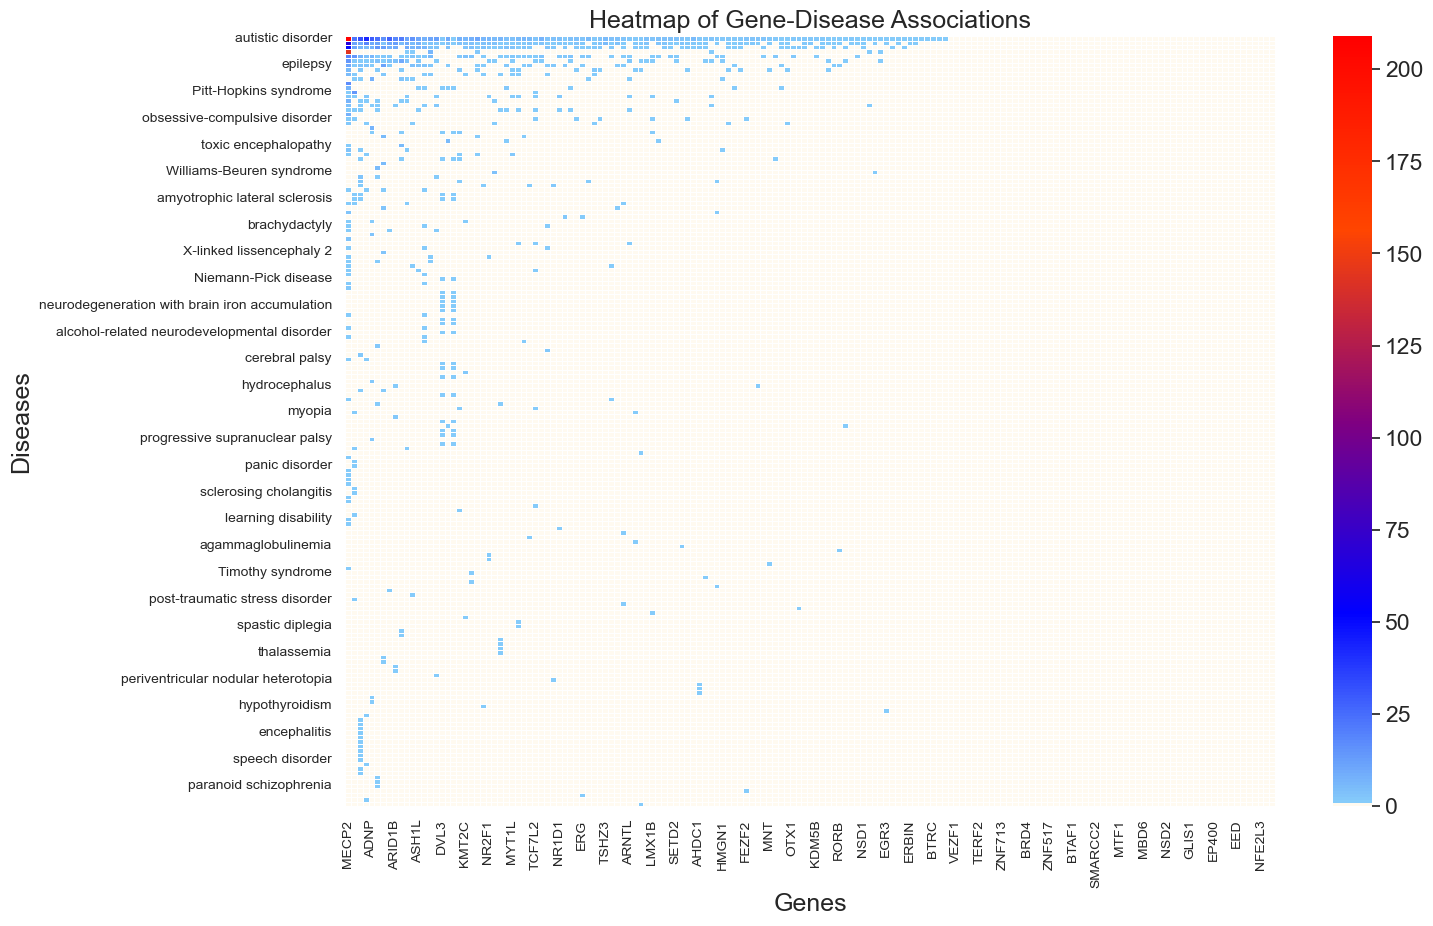

In [7]:
disease_Gene_df = pd.DataFrame(sorted_disease_Gene)
disease_Gene_df.fillna(0, inplace=True)

cmap_list = [
    (0, "floralwhite"),
    (1e-6, "lightskyblue"),
    (0.25, "blue"),
    (0.5, "purple"),
    (0.75, "orangered"),
    (1, "red"),
]

cmap_custom = LinearSegmentedColormap.from_list("custom", cmap_list)

# Sort rows and columns by their sum
sorted_columns = disease_Gene_df.sum(axis=0).sort_values(ascending=False).index
sorted_rows = disease_Gene_df.sum(axis=1).sort_values(ascending=False).index
disease_Gene_df_sorted = disease_Gene_df.loc[sorted_rows, sorted_columns]

# Plot the heatmap
plt.figure(figsize=(15,10))
ax = sns.heatmap(
    disease_Gene_df_sorted,
    cmap=cmap_custom,
    linewidths=0.5,
    annot=False,
    cbar=True,
    norm=plt.Normalize(vmin=0, vmax=np.max(disease_Gene_df_sorted.values))
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel("Genes")
plt.ylabel("Diseases")
plt.title("Heatmap of Gene-Disease Associations")
plt.show()

# Clustered Heatmap of Gene-Disease Associations

1. Create a DataFrame `disease_Gene_df` from the `sorted_disease_Gene` dictionary:
   - Use `pd.DataFrame()` to create a DataFrame from the `sorted_disease_Gene` dictionary.
   - Fill any missing values (NaN) in the DataFrame with 0 using `fillna(0, inplace=True)`.

2. Define the color map for the heatmap:
   - Create a list `cmap_list` that defines the color stops for the color map.
   - Use `LinearSegmentedColormap.from_list()` to create a custom color map `cmap_custom` from the `cmap_list`.

3. Plot the clustered heatmap using `sns.clustermap()`:
   - Pass `disease_Gene_df` as the data for the heatmap.
   - Set `cmap` to the custom color map `cmap_custom`.
   - Set `linewidths` to the desired width of the lines between cells.
   - Set `annot` to `False` to disable cell annotations.
   - Set `cbar` to `True` to include a color bar.
   - Set `figsize` to the desired size of the plot.
   - Set `norm` to `plt.Normalize(vmin=0, vmax=np.max(disease_Gene_df.values))` for color normalization.
   - Set `cbar_pos` to `(1.01, .2, .03, .2)` to adjust the position and size of the color bar.
   - Set `method` to `'ward'` for hierarchical clustering using the Ward method.

4. Adjust the y-axis labels and position:
   - Use `g.ax_heatmap.set_yticklabels()` to adjust the y-axis labels by passing the y-axis tick labels of the heatmap.
   - Use `g.ax_heatmap.yaxis.set_label_coords()` to adjust the position of the y-axis label.

5. Set the x-label, y-label, and title of the plot using `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` respectively.

Note: Ensure that the required libraries (seaborn, matplotlib, pandas, numpy) are imported before executing this code, and that the `sorted_disease_Gene` dictionary is defined and contains the relevant data.


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

disease_Gene_df = pd.DataFrame(sorted_disease_Gene)
disease_Gene_df.fillna(0, inplace=True)

cmap_list = [
    (0, "floralwhite"),
    (1e-6, "lightskyblue"),
    (0.25, "dodgerblue"),
    (0.5, "blue"),
    (0.75, "darkorange"),
    (1, "red"),
]

cmap_custom = LinearSegmentedColormap.from_list("custom", cmap_list)

g = sns.clustermap(
    disease_Gene_df,
    cmap=cmap_custom,
    linewidths=0.5,
    annot=False,
    cbar=True,
    figsize=(100,100),
    norm=plt.Normalize(vmin=0, vmax=np.max(disease_Gene_df.values)),
#     dendrogram_ratio=(.1, .2),
    cbar_pos=(1.01, .2, .03, .2),
    method='ward'
)

# Adjust the y-axis labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10)
g.ax_heatmap.yaxis.set_label_coords(-0.15, 0.5)

plt.xlabel("Genes")
plt.ylabel("Diseases")
plt.title("Clustered Heatmap of Gene-Disease Associations")
plt.show()


# GO Terms

# Gene-Ontology Associations

1. Define the API key and URL for BioPortal:
   - Set `api_key` to your BioPortal API key.
   - Set `url` to the BioPortal annotator URL.

2. Initialize an empty dictionary `ontology_Gene` to store the gene-ontology associations.

3. Loop through the rows of the DataFrame:
   - Extract the text after "Title:" from the 'info' column.
   - Split the 'gene' column by ', ' and store it in a list called `temp_gene`.
   - Use the `find_pref_labels2()` function to get the preferred labels for the text.
   - Pause for a short period of time using `time.sleep()` to avoid rate limits or API restrictions.
   - Update the `ontology_Gene` dictionary for each gene and label combination:
     - If the label exists in the dictionary for the gene, increment the frequency count.
     - Otherwise, add the label to the dictionary for the gene with a frequency count of 1.

4. Print the resulting `ontology_Gene` dictionary.

Note: Ensure that the required libraries and functions (`find_pref_labels2()`, `extract_text_after_title()`) are imported and defined before executing this code, and that the DataFrame `df` contains the relevant data.


In [253]:
api_key = "d9885f69-dfed-44cd-81c3-f0591df67a03"
url = "https://data.bioontology.org/annotator"
ontology_Gene = {key: {} for key in tf}

# Loop through the DataFrame rows
for index, row in df.iterrows():
    # Extract the text after "Title:"
    text = extract_text_after_title(row['info'])

    # Convert row['gene'] to a list called temp_gene
    temp_gene = row['gene'].split(', ')

    # Get the preferred labels using the find_pref_labels function
    pref_labels = find_pref_labels2(api_key, url, text)
    time.sleep(0.1)
    # Update the disease_Freq dictionaries for each tf key in temp_gene based on pref_labels
    for label in pref_labels:
        for gene in temp_gene:
            ontology_Freq = ontology_Gene[gene]

            if label in ontology_Freq:
                ontology_Freq[label] += 1
            else:
                ontology_Freq[label] = 1

# Print the resulting disease_Gene dictionary
print("=========================================")

{'neurogenesis': 1, 'behavior': 1, 'brain development': 3, 'developmental process': 3, 'obsolete RNA': 1, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'obsolete protein': 1, 'translation': 1, 'cytoplasm': 1, 'neuron projection': 1, 'neuron spine': 1, 'biosynthetic process': 1, 'binding': 2, 'obsolete galectin': 1, 'structural constituent of ribosome': 1, 'neuron projection development': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 2, 'chromatin': 1, 'biological regulation': 1, 'gene expression': 1}


In [254]:
print(ontology_Gene)

{'ADNP': {'localization': 2, 'anatomical structure morphogenesis': 1, 'calcium-mediated signaling': 1, 'signaling': 4, 'obsolete protein': 24, 'cytoplasm': 1, 'neuron projection development': 2, 'neuron projection morphogenesis': 1, 'neuron projection': 2, 'biosynthetic process': 15, 'phosphorylation': 1, 'binding': 12, 'developmental process': 13, 'basal dendrite': 1, 'dendrite': 1, 'axon': 1, 'chromatin': 7, 'DNA-templated transcription': 3, 'obsolete RNA': 9, 'microtubule': 16, 'cytoskeleton': 4, 'obsolete mutagenesis': 1, 'behavior': 5, 'gene expression': 6, 'macroautophagy': 5, 'autophagy': 5, 'cell cycle': 1, 'antigen processing and presentation': 1, 'cellular senescence': 1, 'obsolete senescence': 1, 'dendritic spine': 4, 'neuron spine': 4, 'sensory perception of pain': 1, 'biological regulation': 1, 'signal transduction': 1, 'brain development': 3, 'microtubule polymerization or depolymerization': 2, 'axo-dendritic transport': 4, 'axonal transport': 4, 'transport': 4, 'obsolete

# Gene-Ontology Associations Processing

1. Delete key-value pairs in the `ontology_Gene` dictionary where the frequency is 1:
   - Create a new dictionary comprehension `ontology_Gene` that filters out pairs where the frequency is 1.

2. Sort the nested dictionary based on frequency in descending order:
   - Iterate over the `ontology_Gene` dictionary.
   - Sort each nested dictionary by the frequency value in descending order using the `sorted()` function.
   - Update the `ontology_Gene` dictionary with the sorted nested dictionary.

3. Delete empty key-value pairs from the `ontology_Gene` dictionary:
   - Create a new dictionary comprehension `ontology_Gene` that filters out pairs where the value is empty.

Note: Ensure that the `ontology_Gene` dictionary is available and contains the relevant data before executing this code.


In [82]:
# Delete key-value pairs where frequency is 1
ontology_Gene = {gene: {ontology: freq for ontology, freq in ontology_dict.items() if freq > 1}
                for gene, ontology_dict in ontology_Gene.items()}

# Sort the nested dictionary based on frequency in descending order
for gene, ontology_dict in ontology_Gene.items():
    ontology_Gene[gene] = dict(sorted(ontology_dict.items(), key=lambda item: item[1], reverse=True))
    
# Delete empty pairs
ontology_Gene = {k: v for k, v in ontology_Gene.items() if bool(v)}

In [83]:
print(ontology_Gene)

{'ADNP': {'obsolete protein': 24, 'microtubule': 16, 'biosynthetic process': 15, 'developmental process': 13, 'binding': 12, 'obsolete RNA': 9, 'chromatin': 7, 'microtubule end': 7, 'gene expression': 6, 'behavior': 5, 'macroautophagy': 5, 'autophagy': 5, 'memory': 5, 'chromatin remodeling': 5, 'signaling': 4, 'cytoskeleton': 4, 'dendritic spine': 4, 'neuron spine': 4, 'axo-dendritic transport': 4, 'axonal transport': 4, 'transport': 4, 'obsolete neuroprotection': 4, 'cognition': 4, 'obsolete chromatin remodeling complex': 4, 'DNA-templated transcription': 3, 'brain development': 3, 'obsolete aging': 3, 'mRNA cis splicing, via spliceosome': 3, 'localization': 2, 'neuron projection development': 2, 'neuron projection': 2, 'microtubule polymerization or depolymerization': 2, 'sensory perception of sound': 2, 'synapse': 2, 'tooth eruption': 2}, 'AHDC1': {'obsolete DNA': 2, 'binding': 2}, 'AKT3': {'1-phosphatidylinositol-3-kinase activity': 3}, 'Androgen Receptor': {'developmental process'

# Unique Ontology Names

1. Create an empty set called `unique_ontology` to store unique ontology names.

2. Iterate over the `ontology_Gene` dictionary:
   - For each gene in the dictionary, access the associated ontology dictionary.
   - Update the `unique_ontology` set with the keys (ontology names) from the ontology dictionary.

3. Calculate the number of unique ontology names:
   - Get the length of the `unique_ontology` set.

4. Print the result:
   - Display the number of unique ontology names using the formatted string with the `num_unique_diseases` variable.

Note: Ensure that the `ontology_Gene` dictionary is available and contains the relevant data before executing this code.


In [262]:
unique_ontology = set()
for gene, ontology in ontology_Gene.items():
    unique_ontology.update(ontology.keys())

num_unique_diseases = len(unique_ontology)

print(f"There are {num_unique_diseases} unique ontology names in the dictionary.")




There are 160 unique ontology names in the dictionary.


In [76]:
ontology_Gene = {'ADNP': {'localization': 2, 'anatomical structure morphogenesis': 1, 'calcium-mediated signaling': 1, 'signaling': 4, 'obsolete protein': 24, 'cytoplasm': 1, 'neuron projection development': 2, 'neuron projection morphogenesis': 1, 'neuron projection': 2, 'biosynthetic process': 15, 'phosphorylation': 1, 'binding': 12, 'developmental process': 13, 'basal dendrite': 1, 'dendrite': 1, 'axon': 1, 'chromatin': 7, 'DNA-templated transcription': 3, 'obsolete RNA': 9, 'microtubule': 16, 'cytoskeleton': 4, 'obsolete mutagenesis': 1, 'behavior': 5, 'gene expression': 6, 'macroautophagy': 5, 'autophagy': 5, 'cell cycle': 1, 'antigen processing and presentation': 1, 'cellular senescence': 1, 'obsolete senescence': 1, 'dendritic spine': 4, 'neuron spine': 4, 'sensory perception of pain': 1, 'biological regulation': 1, 'signal transduction': 1, 'brain development': 3, 'microtubule polymerization or depolymerization': 2, 'axo-dendritic transport': 4, 'axonal transport': 4, 'transport': 4, 'obsolete hyperphosphorylation': 1, 'sensory perception of sound': 2, 'memory': 5, 'large latent transforming growth factor-beta complex': 1, 'nervous system development': 1, 'system development': 1, 'synapse': 2, 'bacterial microcompartment': 1, 'exploration behavior': 1, 'obsolete neuroprotection': 4, 'cognition': 4, 'microtubule end': 7, 'chromatin remodeling': 5, 'intracellular anatomical structure': 1, 'MAP kinase activity': 1, 'stem cell division': 1, 'obsolete aging': 3, 'deoxyribodipyrimidine photo-lyase activity': 1, 'phosphatase activity': 1, 'glutamatergic synapse': 1, 'tooth eruption': 2, 'membrane': 1, 'sleep': 1, 'obsolete procollagen C-endopeptidase activity': 1, 'obsolete chromatin remodeling complex': 4, 'RNA splicing': 1, 'mRNA cis splicing, via spliceosome': 3, 'translation': 1, 'neural tube closure': 1, 'tube closure': 1, 'heart development': 1, '5-(carboxyamino)imidazole ribonucleotide mutase activity': 1, 'aggressive behavior': 1, 'smooth endoplasmic reticulum': 1, 'postsynaptic density': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'SWI/SNF complex': 1, 'viral nucleocapsid': 1}, 'AHDC1': {'DNA binding': 1, 'obsolete DNA': 2, 'binding': 2, 'sleep': 1, 'obsolete protein': 1, 'brain development': 1, 'developmental process': 1}, 'AKT3': {'1-phosphatidylinositol-3-kinase activity': 3, 'developmental process': 1, 'viral nucleocapsid': 1, 'growth': 1, 'phospholipid binding': 1, 'binding': 1, 'kinase activity': 1}, 'Androgen Receptor': {'behavior': 1, 'signaling': 1, 'initiator methionyl aminopeptidase activity': 1, 'gene expression': 2, 'developmental process': 7, 'brain development': 4, 'obsolete protein': 3, 'cognition': 1, 'M band': 1, 'obsolete RNA': 2, 'extracellular matrix': 1, 'extracellular region': 1, 'signal transduction': 1, 'transduction': 1, 'growth': 1, 'obsolete insulin': 1, 'biological regulation': 4, 'chromatin': 3, 'stem cell proliferation': 1, 'cell population proliferation': 1, 'neuron projection development': 1, 'neuron projection': 1, 'regulation of cell cycle switching, mitotic to meiotic cell cycle': 2, 'chromosome': 3, 'dosage compensation by inactivation of X chromosome': 2, 'RNA-dependent RNA polymerase activity': 1, "5'-3' RNA polymerase activity": 1, "DNA-directed 5'-3' RNA polymerase activity": 1, 'DNA-templated transcription': 1, 'regulation of gene expression': 1, 'translation': 1, 'biosynthetic process': 1, 'cytoskeleton': 1, 'mRNA cis splicing, via spliceosome': 1, 'DNA binding': 1, 'obsolete DNA': 2, 'binding': 2, 'methylation': 1, 'X chromosome': 1}, 'ARID1B': {'DNA-templated transcription': 3, 'dendritic spine': 2, 'neuron spine': 2, 'biological regulation': 3, 'signal transduction': 1, 'signaling': 2, 'developmental process': 13, 'chromatin': 6, 'brain development': 5, 'synapse': 2, 'biosynthetic process': 1, 'synapse organization': 1, 'anatomical structure morphogenesis': 1, 'chromatin remodeling': 3, 'dendritic spine morphogenesis': 1, 'modulation by symbiont of host process': 3, 'induction by symbiont of host programmed cell death': 3, 'modulation by symbiont of host defense response': 3, 'killing by symbiont of host cells': 3, 'hemolysis by symbiont of host erythrocytes': 3, 'cytolysis by symbiont of host cells': 3, 'obsolete RNA': 2, 'behavior': 7, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'obsolete covalent chromatin modification': 1, 'chromatin organization': 1, 'learning': 2, 'obsolete protein': 2, 'gene expression': 3, 'RNA processing': 1, 'developmental growth': 1, 'growth': 3, 'memory': 2, 'regulation of cell cycle': 1, 'cell cycle': 1, 'cell death': 1, 'localization': 1, 'neurogenesis': 1, 'binding': 2, 'chemical synaptic transmission': 2, 'cell differentiation': 1, 'neuron development': 2, 'dendritic shaft': 1, 'cognition': 1, 'obsolete chromatin remodeling complex': 1, 'histone acetylation': 1, 'methylation': 1, 'growth hormone receptor binding': 2, 'viral nucleocapsid': 1, 'DNA binding': 1, 'obsolete DNA': 1, 'social behavior': 2, 'Fas-activated serine/threonine kinase activity': 1, 'insulin-like growth factor receptor binding': 1, 'obsolete insulin': 1, 'chromosome': 1}, 'ARID2': {}, 'ARNT2': {'neurogenesis': 1, 'behavior': 1, 'brain development': 1, 'developmental process': 1, 'obsolete RNA': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'phagophore assembly site': 1, 'transcription regulator complex': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'inhibitory synapse assembly': 1, 'inhibitory synapse': 1, 'synapse': 1, 'biosynthetic process': 1, 'memory': 1, 'obsolete protein': 1, 'localization': 1}, 'ARNTL': {'sleep': 1, 'developmental process': 1, 'obsolete protein': 1, 'behavior': 2, 'memory': 1, 'gene expression': 1, 'social behavior': 1}, 'ARX': {'transporter activity': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 6, 'DNA-templated transcription': 8, 'brain development': 3, 'developmental process': 7, 'obsolete DNA': 1, 'immunoglobulin complex': 1, 'B cell receptor complex': 1, 'antigen binding': 1, 'immunoglobulin complex, circulating': 1, 'phenylalanine dehydrogenase activity': 1, 'obsolete protein': 4, 'modulation by symbiont of host process': 3, 'induction by symbiont of host programmed cell death': 3, 'modulation by symbiont of host defense response': 3, 'killing by symbiont of host cells': 3, 'hemolysis by symbiont of host erythrocytes': 3, 'cytolysis by symbiont of host cells': 3, 'regulation of development, heterochronic': 1, 'social behavior': 1, 'behavior': 1, 'aggressive behavior': 1, 'biological regulation': 4, 'chromosome': 3, 'viral nucleocapsid': 1, 'chromatin': 2, 'regulation of gene expression': 1, 'methylation': 1, 'gene expression': 1, 'histone deacetylase complex': 1, 'X chromosome': 1, 'associative learning': 1, 'learning': 1, 'cell differentiation': 1, 'binding': 1, 'neuroblast proliferation': 1, 'endoplasmic reticulum-Golgi intermediate compartment': 1, 'interneuron migration': 1, 'neuron migration': 1}, 'ASH1L': {'biological regulation': 2, 'chromatin': 4, 'gene expression': 4, 'neurotransmitter transport': 1, 'transport': 1, 'regulation of gene expression': 1, 'viral nucleocapsid': 3, 'sleep': 1, 'developmental process': 4, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'anatomical structure morphogenesis': 1, 'catalytic activity': 1, 'neuron projection development': 1, 'neuron projection': 1, 'nerve growth factor receptor binding': 1, 'neurotrophin receptor binding': 1, 'signal transduction': 2, 'signaling': 2, 'obsolete protein': 3, 'neurotrophin TRK receptor signaling pathway': 1, 'behavior': 1, 'social behavior': 1, 'learning': 2, 'synapse pruning': 1, 'synapse': 2, 'binding': 1, 'ephrin receptor binding': 1, 'obsolete ephrin': 1, 'memory': 3, 'cell development': 1, 'brain development': 2, 'chromatin remodeling': 1, 'translation': 1, 'biosynthetic process': 1, 'cellular metabolic process': 1, 'metabolic process': 1, 'synapse organization': 1, 'CCR4-NOT complex': 1, 'obsolete RNA': 1, 'protein ubiquitination': 1, 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay': 1, 'mRNA catabolic process': 1}, 'ATRX': {'brain development': 1, 'developmental process': 3, 'guanyl-nucleotide exchange factor activity': 1, 'vesicle': 1, 'obsolete RNA': 2, 'telencephalon development': 1, 'chromatin': 2, 'DNA-templated transcription': 1, 'transcription factor binding': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'binding': 1, 'biological regulation': 2, 'signaling': 2, 'protein tag': 1, 'obsolete protein': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'cognition': 1, 'behavior': 1, 'mitotic cell cycle': 1, 'mitotic nuclear division': 1, 'meiotic nuclear division': 1, 'meiotic cell cycle': 1, 'gene expression': 1, 'obsolete DNA': 1, 'DNA methylation': 1, 'methylation': 1, 'mRNA splicing, via spliceosome': 1, 'Group I intron splicing': 1, 'Group III intron splicing': 1, 'RNA splicing, via endonucleolytic cleavage and ligation': 1, 'Group II intron splicing': 1, 'obsolete mRNA splicing': 1, 'mRNA cis splicing, via spliceosome': 1, 'translation': 1, 'ribosome biogenesis': 1, 'ribosome': 1}, 'BAZ2B': {'DNA methylation': 1, 'obsolete DNA': 1, 'methylation': 1, 'signaling': 1, 'gene expression': 1, 'obsolete protein': 1, 'prepulse inhibition': 1, 'viral nucleocapsid': 1, 'molecular_function': 1, 'signaling receptor activity': 1, 'cargo receptor activity': 1, 'cell adhesion': 1, 'antigen processing and presentation': 1, 'signal transduction': 1}, 'BCL11A': {'obsolete protein': 2, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 3, 'DNA-templated transcription': 3, 'brain development': 2, 'developmental process': 2, 'chromatin': 2, 'bioluminescence': 1, 'binding': 2, 'obsolete RNA': 1, 'neurogenesis': 1, 'cell cycle': 1, 'spliceosomal complex': 1, 'gene expression': 1, 'female pregnancy': 1, 'deoxyribodipyrimidine photo-lyase activity': 1, 'regulation of gene expression': 1, 'biological regulation': 1, 'cell population proliferation': 1, 'obsolete globin': 1, 'oxygen carrier activity': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'BRD4': {}, 'BTAF1': {}, 'BTRC': {'mRNA cis splicing, via spliceosome': 1, 'brain development': 1, 'developmental process': 1, 'signaling': 1, 'catabolic process': 1}, 'CAMK2A': {'synaptic signaling': 1, 'signaling': 2, 'synapse': 1, 'biological regulation': 1, 'chromatin': 1, 'chromatin remodeling': 1, 'developmental process': 1, 'viral nucleocapsid': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'CARD11': {}, 'CASZ1': {}, 'Catalase': {'female pregnancy': 2, 'type II interferon receptor binding': 1, 'developmental process': 5, 'memory': 4, 'catalase activity': 9, 'learning': 4, 'behavior': 11, 'superoxide dismutase activity': 3, 'biosynthetic process': 1, 'Fas-activated serine/threonine kinase activity': 1, 'homeostatic process': 1, 'biological regulation': 1, 'protein oxidation': 2, 'obsolete protein': 4, 'mitochondrion': 1, 'respiratory gaseous exchange by respiratory system': 1, 'cellular respiration': 1, 'binding': 2, 'viral nucleocapsid': 1, 'intracellular pH reduction': 1, 'intracellular anatomical structure': 1, 'pH reduction': 1, 'neurotransmitter secretion': 1, 'deoxyribodipyrimidine photo-lyase activity': 2, 'metabolic process': 3, 'guanidinobutyrase activity': 1, 'inflammatory response': 5, 'gene expression': 1, 'maintenance of location': 1, 'lipid metabolic process': 1, 'social behavior': 5, 'NMDA glutamate receptor activity': 1, 'intestinal motility': 3, 'NADH dehydrogenase complex': 2, 'locomotion': 3, 'peroxidase activity': 4, 'glutathione peroxidase activity': 1, 'lactoperoxidase activity': 1, 'catalytic activity': 1, 'brain development': 1, 'antioxidant activity': 1, 'mRNA cis splicing, via spliceosome': 1, 'obsolete RNA': 1, 'signaling': 1, 'catabolic process': 1, 'methylation': 1, 'cellular metabolic process': 1, 'chemical synaptic transmission': 1, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'interleukin-6 receptor binding': 1, 'apoptotic DNA fragmentation': 1, 'obsolete DNA': 1, 'sensory perception of pain': 1}, 'CC2D1A': {'chromatin remodeling': 1, 'chromatin': 1, 'intracellular anatomical structure': 4, 'signaling': 4, 'MAP kinase activity': 1, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'developmental process': 4, 'behavior': 3, 'homeostatic process': 1, 'memory': 4, 'cognition': 1, "3',5'-cyclic-nucleotide phosphodiesterase activity": 1, 'learning': 4, 'obsolete DNA': 1, 'stem cell factor receptor activity': 1, 'macroautophagy': 1, 'autophagy': 1, 'cAMP-mediated signaling': 1, 'obsolete protein': 2, 'phosphoric diester hydrolase activity': 1, 'cAMP response element binding': 1, 'binding': 1, 'dendrite': 1, 'dendritic spine': 1, 'neuron spine': 1, 'visual learning': 1, 'obsolete RNA': 1, 'gene expression': 1}, 'CHAMP1': {}, 'CHD1': {'chromatin remodeling': 1, 'chromatin': 1, 'obsolete DNA': 1, 'binding': 1, 'gene expression': 1, 'brain development': 1, 'developmental process': 1, 'neurogenesis': 1}, 'CHD2': {'chromatin remodeling': 1, 'chromatin': 2, 'obsolete DNA': 3, 'binding': 3, 'gene expression': 2, 'brain development': 2, 'developmental process': 4, 'neurogenesis': 3, 'long-term memory': 1, 'memory': 1, 'chemical synaptic transmission': 1, 'obsolete protein': 2, 'embryo development ending in birth or egg hatching': 1, 'embryo development': 1, 'embryo development ending in seed dormancy': 1, 'animal organ development': 1, 'obsolete regulator of G-protein signaling activity': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'site-specific telomere resolvase activity': 1}, 'CHD3': {'biological regulation': 1, 'chromatin remodeling': 1, 'chromatin': 1, 'gene expression': 1, 'brain development': 1, 'developmental process': 1, 'obsolete DNA': 1, 'DNA-templated transcription': 1, 'binding': 1, 'anatomical structure morphogenesis': 1, 'nucleosome': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'cognition': 1}, 'CHD7': {'chromatin remodeling': 5, 'chromatin': 5, 'obsolete DNA': 4, 'binding': 5, 'gene expression': 4, 'brain development': 2, 'developmental process': 5, 'neurogenesis': 1, 'obsolete protein': 2, 'embryo development ending in birth or egg hatching': 1, 'embryo development': 1, 'embryo development ending in seed dormancy': 1, 'animal organ development': 1, 'biological regulation': 2, 'DNA-templated transcription': 1, 'anatomical structure morphogenesis': 1, 'nucleosome': 1, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'cognition': 1, 'growth': 1, 'sleep': 1, 'regulation of circadian sleep/wake cycle, sleep': 1, 'behavior': 2, 'biosynthetic process': 1, 'myelination': 1, 'chromatin binding': 1, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'methylation': 1, 'neural crest cell migration': 1, 'cell migration': 1, 'DNA binding': 1}, 'CHD9': {}, 'CIC': {'endoplasmic reticulum': 1, 'obsolete protein': 2, 'obsolete secretory pathway': 1, 'neuron spine': 1, 'biosynthetic process': 1, 'citrate (pro-3S)-lyase activity': 1, 'developmental process': 1, 'transcription repressor complex': 1, 'learning': 1, 'memory': 1}, 'CNOT3': {}, 'CREBBP': {'biological regulation': 2, 'chromatin': 1, 'gene expression': 3, 'neurotransmitter transport': 1, 'transport': 1, 'regulation of gene expression': 1, 'brain development': 1, 'developmental process': 3, 'guanyl-nucleotide exchange factor activity': 1, 'signal transduction': 1, 'signaling': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'binding': 1, 'inflammatory response': 1, 'obsolete protein': 1, 'phosphorylation': 1, 'learning': 1, 'social behavior': 1, 'behavior': 1, 'post-translational protein modification': 1}, 'CSDE1': {'developmental process': 1, 'chemical synaptic transmission': 1, 'RNA binding': 1, 'obsolete RNA': 1, 'binding': 1, 'biological regulation': 1, 'obsolete protein': 1, 'dendritic spine': 1, 'neuron spine': 1, 'synapse': 1, 'biosynthetic process': 1, 'growth': 1, 'synapse organization': 1}, 'CTCF': {'methylation': 3, 'dosage compensation by inactivation of X chromosome': 1, 'X chromosome': 1, 'chromosome': 2, 'obsolete protein': 1, 'obsolete DNA': 3, 'chromatin': 3, 'binding': 5, 'regulation of gene expression': 1, 'biological regulation': 2, 'gene expression': 2, 'viral nucleocapsid': 1, 'autosome': 1, 'DNA modification': 1, 'developmental process': 1, 'DNA methylation': 1}, 'CTNNB1': {'obsolete RNA': 1, 'neurogenesis': 1, 'cell cycle': 1, 'spliceosomal complex': 1, 'respiratory gaseous exchange by respiratory system': 1, 'brain development': 1, 'developmental process': 4, 'apoptotic signaling pathway': 1, 'signal transduction': 2, 'signaling': 4, 'cell-cell adhesion': 1, 'cell adhesion': 1, 'biological regulation': 1, 'viral nucleocapsid': 1, 'social behavior': 1, 'behavior': 2, 'excitatory synapse': 1, 'synapse': 1, 'growth': 1, '1-phosphatidylinositol-3-kinase activity': 1, 'cAMP-dependent protein kinase complex': 1, 'cAMP-dependent protein kinase activity': 1, 'obsolete protein': 1}, 'CUL3': {'chromatin': 1, 'histone methylation': 1, 'methylation': 1, 'demethylation': 1, 'viral nucleocapsid': 1, 'NMDA glutamate receptor activity': 1, 'AMPA glutamate receptor complex': 1, 'synaptic signaling': 1, 'signaling': 2, 'DNA-templated transcription': 1, 'cytoskeleton': 2, 'obsolete protein': 3, 'homeostatic process': 1, 'cell migration': 1, 'brain development': 3, 'developmental process': 5, 'protein tag': 3, 'neuron migration': 2, 'actin cytoskeleton organization': 1, 'actin cytoskeleton': 1, 'cytoskeleton organization': 1, 'neurogenesis': 2, 'behavior': 1, 'growth': 1, 'filamentous actin': 1, 'G protein activity': 1, 'dendrite': 1, 'flight': 1, 'neuron development': 1, 'translation': 1, 'chemical synaptic transmission': 2, 'chromosome': 2, 'biological regulation': 2, 'gene expression': 1}, 'CUX1': {'developmental process': 5, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 3, 'DNA-templated transcription': 3, 'brain development': 3, 'neuron migration': 2, 'axon': 1, 'biosynthetic process': 2, 'obsolete protein': 3, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'cell death': 1, 'viral nucleocapsid': 1, 'dendrite': 2, 'growth': 1, 'dendrite development': 2, 'cognition': 1, 'social behavior': 1, 'behavior': 1, 'chromatin': 2, 'cell adhesion mediator activity': 1, 'cell adhesion': 1, 'membrane': 1, 'binding': 1, 'biological regulation': 2, 'obsolete complement factor I activity': 1, 'protein-containing complex': 1, 'immunoglobulin complex': 1, 'B cell receptor complex': 1, 'antigen binding': 1, 'immunoglobulin complex, circulating': 1}, 'CUX2': {'biological regulation': 1, 'developmental process': 1, 'dendrite development': 1, 'dendrite': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1}, 'DDX3X': {'X chromosome': 2, 'chromosome': 2, 'developmental process': 3, 'cell cycle': 1, 'obsolete RNA': 2, 'regulation of cell cycle phase transition': 1, 'cerebral cortex development': 1, 'brain development': 2, 'neurogenesis': 2, 'ribosome': 1, 'translation': 2, 'growth': 1, 'myelination': 1, 'RNA metabolic process': 1, 'metabolic process': 1, 'generation of neurons': 1, 'RNA helicase activity': 1, 'helicase activity': 1, 'obsolete protein': 2, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'deoxyribodipyrimidine photo-lyase activity': 1, 'synapse': 1, 'chromatin binding': 1, 'chromatin': 1, 'binding': 1, 'nucleus': 1}, 'DEAF1': {}, 'DLX2': {'DNA-templated transcription': 2, 'brain development': 2, 'developmental process': 2, 'cell differentiation': 1, 'biological regulation': 1, 'biosynthetic process': 1, 'forebrain development': 1, 'gene expression': 1, 'interneuron migration': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'learning': 1, 'neuron migration': 1, 'chromosome': 1, 'L-lysine 6-oxidase activity': 1}, 'DLX3': {'DNA-templated transcription': 1, 'binding': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'forebrain development': 1, 'developmental process': 1, 'learning': 1, 'brain development': 1, 'viral nucleocapsid': 1, 'chromosome': 1, 'gene expression': 1}, 'DLX6': {'developmental process': 1, 'biological regulation': 1, 'methyl-CpG binding': 1, 'binding': 1, 'obsolete protein': 1, 'genomic imprinting': 1, 'RNA-dependent RNA polymerase activity': 1, "5'-3' RNA polymerase activity": 1, "DNA-directed 5'-3' RNA polymerase activity": 1}, 'DNMT3A': {'obsolete DNA': 7, 'viral nucleocapsid': 1, 'methylation': 7, 'biological regulation': 5, 'gene expression': 2, 'developmental process': 5, 'DNA methylation': 6, 'demethylation': 1, 'brain development': 3, 'embryonic brain development': 1, 'obsolete protein': 3, 'growth': 1, 'binding': 3, 'plasma membrane': 1, 'transmembrane transport': 1, 'membrane': 1, 'transport': 1, 'signaling': 1, 'chromatin': 1, 'DNA-templated transcription': 2, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'hydrolase activity, acting on glycosyl bonds': 1, 'neurogenesis': 1, 'regulation of neurogenesis': 1, 'behavior': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'obsolete DNA hypermethylation': 1, 'learning': 2, 'memory': 2, 'methyl-CpG binding': 1, 'short-term memory': 1, 'long-term memory': 1}, 'DVL3': {'macroautophagy': 1, 'autophagy': 1, 'viral nucleocapsid': 1, 'developmental process': 2, 'maintenance of location': 1, 'glycosylation': 1, '[hydroxymethylglutaryl-CoA reductase (NADPH)] kinase activity': 1, '[acetyl-CoA carboxylase] kinase activity': 1, 'cAMP-dependent protein kinase activity': 1, 'obsolete protein': 1, 'multivesicular body': 1, 'chaperone-mediated autophagy': 1, 'endoplasmic reticulum': 1, 'phosphatase activity': 1, 'membrane': 1, 'TORC1 complex': 1, 'binding': 1, 'vesicle-mediated transport': 1, 'vesicle': 1, 'behavior': 1, 'regulation of development, heterochronic': 1, 'biosynthetic process': 1, 'cerebral cortex development': 1, 'brain development': 1, 'adult behavior': 1}, 'EBF3': {'obsolete protein': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 3, 'DNA-templated transcription': 3, 'binding': 1, 'regulation of gene expression': 1, 'biological regulation': 1, 'developmental process': 3, 'brain development': 2, 'axon guidance': 1, 'axon': 1}, 'EED': {}, 'EGR3': {'social behavior': 1, 'behavior': 1, 'developmental process': 1, 'growth': 1}, 'EN2': {'DNA-templated transcription': 24, 'brain development': 7, 'developmental process': 17, 'cell differentiation': 1, 'obsolete complement factor I activity': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 22, 'biological regulation': 8, 'protein-containing complex': 1, 'obsolete protein': 9, 'immunoglobulin complex': 1, 'B cell receptor complex': 1, 'antigen binding': 1, 'immunoglobulin complex, circulating': 1, 'chromatin': 2, 'gene expression': 6, 'binding': 3, 'neurogenesis': 4, 'regulation of neurogenesis': 1, 'behavior': 6, 'obsolete DNA hypermethylation': 2, 'obsolete DNA': 6, 'DNA methylation': 3, 'methylation': 3, 'neuron apoptotic process': 1, 'execution phase of apoptosis': 2, 'apoptotic process': 2, 'obsolete neuroprotection': 1, 'chemical synaptic transmission': 4, 'nucleus': 2, 'hypersensitivity': 1, 'regionalization': 2, 'midbrain morphogenesis': 1, 'anatomical structure morphogenesis': 2, 'synapse assembly': 1, 'signaling': 10, 'GABAergic neuron differentiation': 1, 'neuron differentiation': 1, 'learning': 7, 'memory': 2, 'biosynthetic process': 3, 'synapse organization': 1, 'synapse': 1, 'obsolete RNA': 2, 'initiator methionyl aminopeptidase activity': 1, 'mRNA cis splicing, via spliceosome': 1, 'innervation': 3, 'growth': 5, 'cell death': 1, 'negative regulation of neuron apoptotic process': 1, 'system development': 1, 'visual learning': 5, 'extracellular region': 4, 'phosphorylation': 2, 'cognition': 1, 'MAP kinase activity': 2, 'ERK1 and ERK2 cascade': 1, 'insulin-like growth factor receptor binding': 3, 'obsolete insulin': 4, 'growth hormone receptor binding': 1, 'vertebrate eye-specific patterning': 1, 'RNA binding': 1, 'cell cycle': 1, 'signal transduction': 1, 'DNA biosynthetic process': 1, 'neuron projection development': 1, 'neuron projection': 1, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'immune response': 1, 'histone H3K27 trimethyltransferase activity': 1, 'histone H3K4 trimethyltransferase activity': 1, 'cell maturation': 1, 'prepulse inhibition': 1, 'receptor ligand activity': 1, 'death-inducing signaling complex': 1, 'chromosome': 1, 'DNA nucleotidylexotransferase activity': 1, 'viral nucleocapsid': 1, 'social behavior': 2, 'aggressive behavior': 1, 'motor behavior': 1, 'chromosomal region': 1, 'female pregnancy': 1}, 'EP300': {}, 'EP400': {}, 'ERBIN': {'obsolete RNA': 1, 'gene expression': 1, 'behavior': 1, 'osteoclast differentiation': 1, 'signal transduction': 1, 'signaling': 1, 'coagulation': 1, 'obsolete protein': 1, 'viral nucleocapsid': 1}, 'ERG': {'developmental process': 1, 'acetylcholine-gated channel complex': 1, 'acetylcholine-gated monoatomic cation-selective channel activity': 1, 'binding': 1, 'long-term synaptic potentiation': 1, 'visual learning': 1, 'learning': 1}, 'ESR2': {'methylation': 1, 'brain development': 1, 'developmental process': 1, 'obsolete protein': 1, 'biological regulation': 1, 'obsolete DNA': 1, 'DNA methylation': 1}, 'ESRRB': {}, 'EZH2': {'chromatin': 1, 'behavior': 2, 'social behavior': 1, 'learning': 1, 'synapse pruning': 1, 'synapse': 1, 'binding': 1, 'ephrin receptor binding': 1, 'obsolete ephrin': 1, 'obsolete RNA': 3, 'gene expression': 2, 'osteoclast differentiation': 1, 'signal transduction': 1, 'signaling': 1, 'coagulation': 1, 'obsolete protein': 1, 'viral nucleocapsid': 1, 'biological regulation': 2, 'chromosome': 1, 'DNA-templated transcription': 2, 'regulation of gene expression': 1}, 'FAN1': {'acetylcholine-gated channel complex': 1, 'acetylcholine-gated monoatomic cation-selective channel activity': 1, 'binding': 1, 'long-term synaptic potentiation': 1, 'visual learning': 1, 'learning': 1, 'behavior': 1, 'sensory processing': 1}, 'FBN1': {}, 'FEZF2': {'chromatin': 1, 'gene expression': 2, 'female pregnancy': 2, 'deoxyribodipyrimidine photo-lyase activity': 1, 'regulation of gene expression': 1, 'biological regulation': 1, 'biosynthetic process': 1, 'capsule': 1, 'nucleus': 1, 'bacterial microcompartment': 1, 'developmental process': 1, 'axon': 1, 'cell adhesion': 1, 'growth cone': 1, 'growth': 1, 'extracellular matrix': 1, 'extracellular region': 1, 'cognition': 2, 'inflammatory response': 1, 'neurogenesis': 1, 'social behavior': 1, 'behavior': 1}, 'FOXG1': {'social behavior': 2, 'behavior': 2, 'DNA methylation': 1, 'obsolete DNA': 4, 'methylation': 1, 'gene expression': 2, 'brain development': 4, 'developmental process': 8, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 4, 'DNA-templated transcription': 5, 'modulation by symbiont of host process': 3, 'induction by symbiont of host programmed cell death': 3, 'modulation by symbiont of host defense response': 3, 'killing by symbiont of host cells': 3, 'hemolysis by symbiont of host erythrocytes': 3, 'cytolysis by symbiont of host cells': 3, 'biosynthetic process': 3, 'obsolete RNA': 3, 'biological regulation': 2, 'regulation of development, heterochronic': 1, 'binding': 3, 'obsolete protein': 2, 'cyclin-dependent protein serine/threonine kinase regulator activity': 1, 'homeostatic process': 1, 'mitochondrial chromosome': 1, 'methyl-CpG binding': 1, 'MAPK cascade': 1, 'MAP kinase activity': 1, 'signaling': 2, 'chromatin': 2, 'chromosome': 2, 'cerebral cortex development': 1, 'cognition': 1, 'neurogenesis': 1, 'neuron differentiation': 1, 'cell population proliferation': 1, 'cell cycle': 1, 'ncRNA-mediated post-transcriptional gene silencing': 1, 'viral nucleocapsid': 1, 'growth': 1, 'sleep': 1}, 'FOXP1': {'biological regulation': 5, 'regulation of cell cycle switching, mitotic to meiotic cell cycle': 1, 'obsolete protein': 9, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 9, 'DNA-templated transcription': 12, 'brain development': 9, 'developmental process': 18, 'chromatin': 2, 'bioluminescence': 1, 'binding': 4, 'cognition': 3, 'growth hormone receptor binding': 1, 'growth': 1, 'DNA methylation': 2, 'obsolete DNA': 4, 'methylation': 2, 'obsolete insulin': 1, 'memory': 4, 'gene expression': 6, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'glycine dehydrogenase (decarboxylating) activity': 3, 'mitochondrial membrane': 1, 'membrane': 1, 'NADH dehydrogenase complex': 2, 'neuron projection arborization': 1, 'neuron projection': 1, 'learning': 4, 'behavior': 6, 'associative learning': 1, 'autophagy of mitochondrion': 1, 'mitophagy': 1, 'deoxyribodipyrimidine photo-lyase activity': 2, 'obsolete apoptogenic cytochrome c release channel activity': 1, 'aggressive behavior': 1, 'obsolete RNA': 3, 'mRNA cis splicing, via spliceosome': 2, 'transporter activity': 1, 'central nervous system development': 1, 'neuron development': 1, 'axon ensheathment': 1, 'axon': 1, 'synapse': 1, 'synaptic vesicle cycle': 1, 'synaptic vesicle': 1, 'vesicle': 1, 'signaling receptor activity': 1, 'signaling': 4, 'cargo receptor activity': 1, 'inflammatory response': 1, 'chromosome': 1, 'embryo development ending in birth or egg hatching': 1, 'embryo development': 1, 'embryo development ending in seed dormancy': 1, 'neurogenesis': 3, 'biosynthetic process': 1, 'cerebral cortex development': 2, 'eating behavior': 1, 'feeding behavior': 1, 'muscle cell proliferation': 1, 'cell population proliferation': 1, 'macroautophagy': 1, 'autophagy': 1, 'cytoplasm': 1, 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay': 1, 'mRNA catabolic process': 1, 'stem cell differentiation': 1, 'cell differentiation': 1, 'astrocyte differentiation': 1, 'neuron migration': 1, 'protein sumoylation': 1, 'embryonic brain development': 1, 'NuRD complex': 1, 'sleep': 1, 'visual learning': 1, 'long-term synaptic potentiation': 1, 'regulation of gene expression': 1, 'localization': 1, 'vocal learning': 1, 'nucleus': 1, 'motor behavior': 1, 'anatomical structure morphogenesis': 1}, 'FOXP2': {'obsolete protein': 11, 'sensory perception of sound': 2, 'behavior': 10, 'obsolete RNA': 5, 'memory': 3, 'biosynthetic process': 2, 'biological regulation': 10, 'regulation of cell cycle switching, mitotic to meiotic cell cycle': 1, 'DNA-templated transcription': 17, 'brain development': 8, 'developmental process': 17, 'cell differentiation': 1, 'cell adhesion mediator activity': 1, 'cell adhesion': 2, 'membrane': 1, 'binding': 8, 'gene expression': 6, 'vocal learning': 3, 'learning': 4, 'nucleus': 1, 'motor behavior': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 12, 'obsolete DNA': 5, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'viral nucleocapsid': 1, 'signaling': 6, 'extracellular matrix organization': 1, 'extracellular matrix': 1, 'extracellular region': 1, 'translation': 1, 'social behavior': 4, 'mating': 2, 'parasexual reproduction with cellular fusion': 2, 'conjugation with cellular fusion': 2, 'aggressive behavior': 1, 'negative regulation of heterochromatin formation': 1, 'chromatin': 1, 'neuron maturation': 1, 'transcription factor binding': 1, 'obsolete importin, alpha-subunit transport factor': 1, 'lactation': 1, 'grooming behavior': 1, 'biological_process': 1, 'cognition': 3, 'antigen processing and presentation': 1, 'metabolic process': 1, 'catabolic process': 1, 'axonogenesis': 1, 'Lewy body': 1, 'mRNA processing': 1, 'cell-cell adhesion': 1, 'cytoskeleton organization': 1, 'cytoskeleton': 1, 'inflammatory response': 1, 'nervous system development': 1, 'system development': 1, 'neurogenesis': 1, 'age-related resistance': 1, 'synapse': 1, 'synapse assembly': 1, 'DNA binding': 1, 'plasminogen activation': 1, 'urokinase plasminogen activator receptor activity': 1, 'obsolete plasminogen activator activity': 1, 'obsolete neuroligin': 1, 'neurexin family protein binding': 1, 'regulation of gene expression': 1, 'viral process': 1, 'interleukin-12 complex': 1, 'interleukin-35 complex': 1, 'chromosome': 1}, 'GLIS1': {}, 'GPC3': {}, 'GTF2I': {'DNA-templated transcription': 3, 'binding': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 3, 'forebrain development': 1, 'developmental process': 4, 'learning': 2, 'brain development': 2, 'DNA methylation': 1, 'obsolete DNA': 1, 'methylation': 1, 'gene expression': 3, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'obsolete protein': 1, 'behavior': 2, 'chromosome': 1, 'habituation': 2, 'dishabituation': 1, 'thigmotaxis': 1, 'sensory perception of smell': 1, 'biological regulation': 1, 'social behavior': 2, 'localization': 1, 'mRNA cis splicing, via spliceosome': 1, 'translation': 1, 'nucleus': 1, 'hypersensitivity': 1, 'neural tube closure': 1, 'tube closure': 1, 'memory': 1}, 'HDAC4': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'developmental process': 4, 'biological regulation': 1, 'viral nucleocapsid': 1, 'chromatin': 1, 'obsolete protein': 1, 'DNA methylation': 1, 'obsolete DNA': 1, 'methylation': 1, 'behavior': 1, 'synaptic membrane': 1, 'membrane': 1, 'gene expression': 1, 'complement component C1q complex': 1, 'chromosome': 2, 'sleep': 1, 'mRNA cis splicing, via spliceosome': 1, 'heart development': 1, 'ossification': 1, 'molecular_function': 1}, 'HIVEP2': {'aggressive behavior': 1}, 'HIVEP3': {}, 'HMGN1': {'brain development': 1, 'developmental process': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 2, 'learning': 1, 'chromatin': 1, 'binding': 1, 'obsolete protein': 1, 'behavior': 1, 'chromosome': 1, 'obsolete DNA': 1}, 'JARID2': {'chromosomal region': 1}, 'KDM2A': {}, 'KDM5A': {'biological regulation': 1, 'methylation': 2, 'brain development': 3, 'developmental process': 3, 'chromatin': 2, 'gene expression': 1, 'histone deacetylase complex': 1, 'anatomical structure morphogenesis': 1, 'social behavior': 1, 'behavior': 1, 'signal transduction': 1, 'signaling': 1, 'homeostatic process': 1, 'post-translational protein modification': 1, 'molecular_function': 1}, 'KDM5B': {'social behavior': 1, 'behavior': 1, 'signal transduction': 1, 'signaling': 1, 'homeostatic process': 1, 'methylation': 1, 'post-translational protein modification': 1, 'molecular_function': 1, 'brain development': 1, 'developmental process': 1, 'chromatin': 1}, 'KDM5C': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 2, 'phenylalanine dehydrogenase activity': 1, 'obsolete protein': 1, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'regulation of development, heterochronic': 1, 'biological regulation': 3, 'methylation': 4, 'brain development': 3, 'developmental process': 3, 'chromatin': 5, 'gene expression': 2, 'histone deacetylase complex': 1, 'social behavior': 2, 'behavior': 3, 'signal transduction': 1, 'signaling': 1, 'homeostatic process': 1, 'post-translational protein modification': 1, 'molecular_function': 1, 'sex chromosome': 1, 'chromosome': 2, 'obsolete RNA': 2, 'chromatin remodeling': 1, 'dosage compensation by inactivation of X chromosome': 1, 'X chromosome': 1, 'mRNA cis splicing, via spliceosome': 1, 'regulation of gene expression': 2, 'obsolete DNA': 1, 'sleep': 1, 'translation': 1, 'proteasome-activating nucleotidase complex': 1, 'neuron projection development': 1, 'neuron projection morphogenesis': 1, 'neuron projection': 1, 'growth': 1, 'anatomical structure morphogenesis': 1}, 'KLF16': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'chromosome': 1, 'chromatin': 1, 'obsolete DNA': 1}, 'KLF7': {'behavior': 2, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 2, 'cell population proliferation': 2, 'circadian rhythm': 1, 'rhythmic process': 1, 'biological regulation': 2, 'homeostatic process': 1, 'developmental process': 1, 'obsolete RNA': 1, 'viral nucleocapsid': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'KMT2A': {'biological regulation': 2, 'methylation': 2, 'brain development': 2, 'developmental process': 4, 'chromatin': 5, 'gene expression': 2, 'histone deacetylase complex': 1, 'post-translational protein modification': 1, 'molecular_function': 1, 'behavior': 1, 'social behavior': 1, 'sex chromosome': 1, 'chromosome': 1, 'sleep': 1, 'obsolete RNA': 1, 'neurogenesis': 1, 'DNA-templated transcription': 1}, 'KMT2C': {'biological regulation': 2, 'methylation': 2, 'brain development': 2, 'developmental process': 3, 'chromatin': 2, 'gene expression': 2, 'histone deacetylase complex': 1, 'obsolete protein': 1, 'deoxyribodipyrimidine photo-lyase activity': 1, 'synapse': 1, 'post-translational protein modification': 1, 'molecular_function': 1, 'behavior': 1, 'initiator methionyl aminopeptidase activity': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'LMX1B': {'developmental process': 2, 'inflammatory response': 1, 'brain development': 1, 'obsolete protein': 1, 'obsolete RNA': 1, 'DNA methylation': 1, 'obsolete DNA': 1, 'methylation': 1, 'ATP biosynthetic process': 1, 'biosynthetic process': 1, 'mitochondrial respirasome': 1, 'respirasome': 1, 'mitochondrial translation': 1, 'translation': 1, 'autophagy of mitochondrion': 1, 'mitophagy': 1, 'feeding behavior': 1, 'transdifferentiation': 1, 'serotonin uptake': 1, 'import across plasma membrane': 1, 'import into cell': 1, 'chemical synaptic transmission': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1}, 'MBD1': {'binding': 3, 'obsolete protein': 3, 'DNA methylation': 2, 'obsolete DNA': 2, 'methylation': 2, 'biological regulation': 3, 'neurogenesis': 2, 'learning': 2, 'cell differentiation': 1, 'growth': 1, 'hindbrain development': 1, 'developmental process': 2, 'brain development': 2, 'chromatin': 1, 'ncRNA-mediated post-transcriptional gene silencing': 1, 'obsolete RNA': 1, 'methyl-CpG binding': 1, 'regulation of gene expression': 1, 'viral nucleocapsid': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'MBD3': {}, 'MBD4': {'biological regulation': 1, 'binding': 1, 'obsolete protein': 1, 'growth': 1, 'hindbrain development': 1, 'developmental process': 1, 'brain development': 1, 'chromatin': 1, 'ncRNA-mediated post-transcriptional gene silencing': 1, 'obsolete RNA': 1}, 'MBD6': {}, 'MECP2': {'methylation': 25, 'dosage compensation by inactivation of X chromosome': 3, 'X chromosome': 4, 'chromosome': 19, 'obsolete protein': 136, 'obsolete DNA': 45, 'chromatin': 27, 'binding': 126, 'developmental process': 95, 'synapse': 9, 'brain development': 33, 'guanyl-nucleotide exchange factor activity': 1, 'methyl-CpG binding': 29, 'genomic imprinting': 2, 'RNA-dependent RNA polymerase activity': 1, "5'-3' RNA polymerase activity": 1, "DNA-directed 5'-3' RNA polymerase activity": 1, 'biological regulation': 46, 'embryonic brain development': 2, 'DNA methylation': 20, 'growth': 22, 'gene expression': 35, 'neurogenesis': 7, 'regulation of neurogenesis': 1, 'behavior': 40, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 11, 'DNA-templated transcription': 24, 'obsolete DNA hypermethylation': 1, 'learning': 19, 'memory': 17, 'short-term memory': 1, 'long-term memory': 1, 'biosynthetic process': 21, 'cyclin-dependent protein serine/threonine kinase regulator activity': 1, 'homeostatic process': 8, 'mitochondrial chromosome': 1, 'MAPK cascade': 2, 'MAP kinase activity': 3, 'signaling': 27, 'modulation by symbiont of host process': 24, 'induction by symbiont of host programmed cell death': 24, 'modulation by symbiont of host defense response': 24, 'killing by symbiont of host cells': 24, 'hemolysis by symbiont of host erythrocytes': 24, 'cytolysis by symbiont of host cells': 24, 'viral nucleocapsid': 13, 'sleep': 5, 'translation': 7, 'proteasome-activating nucleotidase complex': 1, 'hindbrain development': 1, 'ncRNA-mediated post-transcriptional gene silencing': 4, 'obsolete RNA': 18, 'social behavior': 11, 'chemical synaptic transmission': 9, 'sensory processing': 4, 'reflex': 2, 'transduction': 4, 'purine deoxyribosyltransferase activity': 1, 'segmentation': 1, 'cell growth': 1, 'thiol S-methyltransferase activity': 1, 'initiator methionyl aminopeptidase activity': 3, 'motor learning': 2, 'dendritic spine': 10, 'neuron spine': 14, 'signal transduction': 5, 'damaged DNA binding': 1, 'obsolete DNA repair protein': 1, 'DNA repair': 1, 'negative regulation of kinase activity': 1, 'innervation': 2, 'regulation of cell cycle switching, mitotic to meiotic cell cycle': 2, 'myelination': 2, 'endoplasmic reticulum-Golgi intermediate compartment': 2, 'deoxyribodipyrimidine photo-lyase activity': 4, 'cytosine binding': 1, 'regulation of gene expression': 4, 'synapse assembly': 7, 'membrane': 5, 'obsolete spanning component of plasma membrane': 1, 'extracellular region': 5, 'inflammatory response': 4, 'female pregnancy': 4, 'Fas-activated serine/threonine kinase activity': 1, '5-(carboxyamino)imidazole ribonucleotide mutase activity': 3, 'signaling receptor activity': 2, 'cargo receptor activity': 2, 'cognition': 3, 'nuclear pore': 1, 'neuron projection development': 3, 'neuron projection': 4, 'taurine-pyruvate aminotransferase activity': 1, 'obsolete plasminogen activator activity': 1, 'histone acetylation': 1, 'intracellular anatomical structure': 5, 'interleukin-6 receptor binding': 2, 'maintenance of location': 1, 'immune response': 1, '1-phosphatidylinositol-3-kinase activity': 2, 'terminal bouton': 1, 'obsolete DNA hypomethylation': 2, 'deoxyribonuclease I activity': 1, 'hypersensitivity': 2, 'phosphorylation': 8, 'synapse maturation': 3, 'calmodulin-dependent protein kinase activity': 2, 'calcium- and calmodulin-dependent protein kinase complex': 2, 'mitochondrion': 2, 'localization': 3, 'cell population proliferation': 1, 'mitochondrial membrane': 1, 'mitochondrion distribution': 1, 'mitochondrial fission': 1, 'dendrite': 2, 'neurotrophin TRK receptor signaling pathway': 1, 'pyramidal neuron migration to cerebral cortex': 1, 'neuron migration': 2, 'neuron projection morphogenesis': 1, 'neuron differentiation': 1, 'respiratory gaseous exchange by respiratory system': 11, 'extracellularly glycine-gated ion channel activity': 1, 'extracellularly glycine-gated chloride channel activity': 1, 'cAMP-dependent protein kinase complex': 1, 'cAMP-dependent protein kinase activity': 1, 'myosin-light-chain-phosphatase activity': 1, 'phosphatase activity': 1, 'axon': 1, 'phagocytosis': 2, 'hemopoiesis': 1, 'yolk': 1, 'spindle assembly checkpoint signaling': 1, 'subapical complex': 1, 'cytokine production': 3, 'secretion': 3, 'regulation of phagocytosis': 1, 'obsolete neuroprotection': 1, 'serotonin biosynthetic process': 1, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'protein kinase B signaling': 2, 'macrophage activation': 1, 'extracellular matrix': 1, 'response to heat': 1, 'retrotransposition': 1, 'obsolete mutagenesis': 1, 'cell quiescence': 1, 'nerve growth factor receptor binding': 2, 'neurotrophin receptor binding': 2, 'exocytosis': 1, 'mRNA transcription': 1, 'ribosome': 1, 'cytoskeleton organization': 1, 'cytoskeleton': 1, 'cytoskeletal motor activity': 1, 'startle response': 2, 'cellular respiration': 2, 'metabolic process': 2, 'oxidoreductase activity, acting on single donors with incorporation of molecular oxygen': 1, 'nucleosome binding': 1, 'nucleosome': 1, 'post-translational protein modification': 1, 'locomotion': 2, 'insulin-like growth factor receptor binding': 4, 'obsolete insulin': 5, 'DNA binding': 3, 'long-term synaptic potentiation': 7, 'exploration behavior': 1, 'AMPA glutamate receptor complex': 1, 'miRNA processing': 2, 'site-specific telomere resolvase activity': 1, 'nucleus': 2, 'obsolete promoter binding': 1, 'endocrine signaling': 1, 'DNA demethylation': 2, 'demethylation': 2, 'base-excision repair': 1, 'obsolete adrenocorticotropin': 1, 'organelle membrane contact site': 1, 'dendritic spine development': 1, 'tricarboxylic acid cycle': 1, 'cell adhesion': 1, 'cell-cell signaling': 1, 'protein sumoylation': 1, 'acetylcholine-gated monoatomic cation-selective channel activity': 1, 'dosage compensation': 1, 'obsolete covalent chromatin modification': 1, 'chromatin organization': 1, 'chromatin remodeling': 4, 'action potential': 2, 'synapse organization': 2, 'neutrophil extracellular trap': 1, 'obsolete DNA methylation or demethylation': 1, 'cell fate commitment': 1, 'viral process': 1, 'postsynaptic density': 2, 'obsolete neuroligin': 2, 'neurexin family protein binding': 2, 'regulation of translation': 1, 'mRNA cis splicing, via spliceosome': 3, 'lysosome': 1, 'cholesterol homeostasis': 1, 'cholesterol biosynthetic process': 1, 'cholesterol metabolic process': 1, 'lipid metabolic process': 1, 'NMDA glutamate receptor activity': 2, 'RNA biosynthetic process': 1, 'synaptic vesicle': 1, 'vesicle': 1, 'synaptic transmission, glutamatergic': 1, 'action potential initiation': 1, 'nervous system development': 1, 'system development': 1, 'habituation': 1, 'associative learning': 1, 'regulation of DNA-templated transcription': 1, 'synaptic cleft': 1, 'protein catabolic process': 1, 'catabolic process': 1, 'gamma-aminobutyric acid reuptake': 1, 'microtubule': 1, 'glutamate biosynthetic process': 1, 'gap junction': 2, 'gap junction channel activity': 1, 'visual learning': 1, 'immunoglobulin complex': 2, 'B cell receptor complex': 2, 'antigen binding': 2, 'immunoglobulin complex, circulating': 2, 'SWI/SNF complex': 1, 'septation initiation signaling': 1, 'heterochromatin': 2, 'feeding behavior': 1, 'aggressive behavior': 1, 'response to stress': 1, 'negative regulation of gene expression, epigenetic': 1, 'negative regulation of gene expression': 1, 'inhibitory postsynaptic potential': 1, 'chromosomal region': 1, 'histone modification': 1, 'RNA splicing': 2, 'transcription factor binding': 1, 'spontaneous synaptic transmission': 1, 'neurotransmitter secretion': 1, 'regulation of RNA splicing': 1, 'regulation of mRNA cis splicing, via spliceosome': 1, 'chromosome organization': 1}, 'MEF2C': {'brain development': 4, 'developmental process': 7, 'cognition': 1, 'gene expression': 6, 'M band': 1, 'biological regulation': 3, 'chromosome': 1, 'obsolete RNA': 2, 'DNA-templated transcription': 7, 'vocal learning': 1, 'learning': 2, 'synapse': 5, 'synapse assembly': 1, 'biosynthetic process': 4, 'DNA binding': 2, 'obsolete DNA': 2, 'binding': 2, 'signaling': 2, 'hypersensitivity': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 4, 'sensory perception of sound': 1, 'myelination': 1, 'mitochondrion': 1, 'macrophage activation': 1, 'inflammatory response': 1, 'inner ear development': 1, 'ear development': 1, 'behavior': 2, 'embryonic brain development': 1, 'growth': 1, 'obsolete calcium-dependent cell adhesion molecule activity': 1, 'obsolete protein': 2, 'complement-mediated synapse pruning': 1, 'excitatory synapse pruning': 1, 'synapse pruning': 1, 'chemical synaptic transmission': 3, 'neurogenesis': 3, 'neuron death': 1, 'cell death': 1, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'Fas-activated serine/threonine kinase activity': 1, 'import across plasma membrane': 1, 'import into cell': 1, 'TSC1-TSC2 complex': 1, 'tryptophan metabolic process': 1, 'metabolic process': 1, 'synaptic signaling': 1, 'memory': 1, 'central nervous system development': 1, 'nervous system development': 1, 'system development': 1, 'neuron spine': 1, 'embryo development ending in birth or egg hatching': 1, 'embryo development': 1, 'embryo development ending in seed dormancy': 1, 'long-term synaptic potentiation': 1, 'neuron migration': 1, 'cell differentiation': 1}, 'MEIS2': {'biological regulation': 1, 'DNA-templated transcription': 2, 'behavior': 1, 'neuron development': 1, 'developmental process': 2, 'phosphatase activity': 1, 'endosome': 1, 'obsolete clathrin-coated pit assembly': 1, 'clathrin-coated pit': 1, 'biosynthetic process': 1, 'actin filament polymerization': 1, 'obsolete RNA': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'gene expression': 1, 'obsolete protein': 1, 'telencephalon development': 1, 'pallium development': 1, 'nuclear pore': 1}, 'MKX': {}, 'MNT': {'developmental process': 1, 'learning': 1, 'micronucleus': 1, 'proteasome-activating nucleotidase complex': 1}, 'MSX2': {}, 'MTF1': {}, 'MYT1L': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 3, 'DNA-templated transcription': 3, 'habituation': 1, 'learning': 1, 'motor learning': 1, 'behavior': 1, 'memory': 1, 'social behavior': 1, 'biological regulation': 1, 'brain development': 1, 'developmental process': 1, 'gene expression': 1, 'chromatin': 1, 'chromosome': 1}, 'NCOA1': {}, 'NCOR1': {}, 'NFE2L3': {}, 'NFIA': {'negative regulation of heterochromatin formation': 1, 'chromatin': 1, 'neuron maturation': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 4, 'developmental process': 4, 'obsolete DNA': 1, 'binding': 1, 'chemical synaptic transmission': 1, 'obsolete complement factor I activity': 2, 'obsolete protein': 1, 'obsolete RNA': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'membrane': 1, 'cell adhesion': 1, 'regulation of neuron migration': 1, 'biological regulation': 1, 'neuron migration': 1}, 'NFIB': {'obsolete complement factor I activity': 3, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 4, 'biological regulation': 1, 'protein-containing complex': 1, 'obsolete protein': 2, 'immunoglobulin complex': 1, 'B cell receptor complex': 1, 'antigen binding': 1, 'immunoglobulin complex, circulating': 1, 'chromatin': 2, 'negative regulation of heterochromatin formation': 1, 'neuron maturation': 1, 'developmental process': 3, 'obsolete DNA': 1, 'binding': 1}, 'NFIX': {'obsolete complement factor I activity': 2, 'DNA-templated transcription': 2, 'developmental process': 2, 'obsolete protein': 1}, 'NKX2-2': {'chromatin remodeling': 1, 'chromatin': 1, 'biosynthetic process': 1, 'myelination': 1, 'developmental process': 2, 'chromatin binding': 1, 'binding': 1, 'execution phase of apoptosis': 1, 'apoptotic process': 1, 'stem cell differentiation': 1, 'cell differentiation': 1, 'biological regulation': 1, 'brain development': 1, 'nuclear pore': 1, 'social behavior': 1, 'behavior': 1, 'neurogenesis': 1, 'gene expression': 1}, 'NPAS2': {}, 'NR1D1': {'sleep': 2, 'DNA-templated transcription': 2, 'viral nucleocapsid': 2, 'biological regulation': 3, 'obsolete RNA': 1, 'gene expression': 2, 'behavior': 2, 'dopamine biosynthetic process': 1, 'biosynthetic process': 2, 'obsolete protein': 2, 'brain development': 2, 'developmental process': 1, 'cerebral cortex development': 1, 'axon extension': 1, 'axon': 1, 'neuron migration': 1, 'maternal behavior': 1, 'cell septum': 1, 'fatty acid binding': 1, 'binding': 1, 'growth': 1, 'macrophage colony-stimulating factor receptor activity': 1}, 'NR2F1': {'vocal learning': 1, 'learning': 2, 'gene expression': 1, 'neuron differentiation': 1, 'developmental process': 2, 'smoothened signaling pathway': 1, 'signal transduction': 1, 'signaling': 1, 'chemical synaptic transmission': 1, 'obsolete DNA': 1, 'binding': 1, 'visual perception': 1, 'long-term memory': 1, 'memory': 2, 'sleep': 1, 'obsolete protein': 1, 'obsolete RNA': 1, 'growth': 1, 'behavior': 1, 'cell maturation': 1, 'DNA-templated transcription': 1}, 'NR3C2': {}, 'NR4A2': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'obsolete RNA': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'membrane': 1, 'cell adhesion': 1, 'regulation of neuron migration': 1, 'biological regulation': 1, 'neuron migration': 1, 'DNA methylation': 1, 'obsolete DNA': 1, 'methylation': 1, 'spermatogenesis': 1}, 'NSD1': {'biological regulation': 1, 'chromatin': 1, 'gene expression': 1, 'neurotransmitter transport': 1, 'transport': 1, 'regulation of gene expression': 1}, 'NSD2': {}, 'OTX1': {'DNA-templated transcription': 2, 'brain development': 1, 'developmental process': 1, 'cell differentiation': 1, 'gene expression': 1, 'obsolete RNA': 1}, 'PAX5': {'immunoglobulin complex': 1, 'B cell receptor complex': 1, 'antigen binding': 1, 'immunoglobulin complex, circulating': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 3, 'learning': 1, 'anatomical structure morphogenesis': 1, 'neurogenesis': 1, 'brain development': 1, 'developmental process': 2, 'cerebellum development': 1, 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay': 1, 'mRNA catabolic process': 1, 'behavior': 1, 'cytosolic alpha-ketoglutarate dehydrogenase complex': 1, 'dihydrolipoyl dehydrogenase complex': 1, 'mitochondrial alpha-ketoglutarate dehydrogenase complex': 1, 'oxoglutarate dehydrogenase complex': 1, 'plastid pyruvate dehydrogenase complex': 1, 'gene expression': 1, 'B cell differentiation': 1, 'cell differentiation': 1, 'obsolete DNA': 1, 'methanol-5-hydroxybenzimidazolylcobamide Co-methyltransferase activity': 1}, 'PBX1': {}, 'PHF21A': {'methylation': 2, 'post-translational protein modification': 1, 'molecular_function': 1, 'brain development': 2, 'developmental process': 2, 'chromatin': 2, 'obsolete protein': 1, 'obsolete DNA': 1, 'histone methylation': 1, 'gene expression': 1}, 'PIK3CA': {'1-phosphatidylinositol-3-kinase activity': 3, 'developmental process': 3, 'viral nucleocapsid': 2, 'growth': 1, 'axon guidance': 1, 'axon': 1, 'gene expression': 1, 'signal transduction': 3, 'signaling': 4, 'obsolete DNA': 1, 'site-specific telomere resolvase activity': 1, 'chromosome': 1, 'narrow pore, gated channel activity': 1, 'metabolic process': 1, 'brain development': 1, 'cell communication': 1}, 'PITX1': {}, 'PRR12': {'obsolete protein': 1, 'developmental process': 1, 'visual perception': 1, 'eye development': 1}, 'RERE': {'viral nucleocapsid': 1, 'visual perception': 1, 'chromosome': 1, 'signaling': 1, 'obsolete DNA': 1}, 'RFX3': {'DNA-templated transcription': 1, 'behavior': 1, 'central nervous system development': 1, 'nervous system development': 1, 'system development': 1, 'developmental process': 1, 'cilium assembly': 1, 'hypersensitivity': 1, 'sleep': 1, 'binding': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'RFX4': {'DNA-templated transcription': 1, 'behavior': 1, 'central nervous system development': 1, 'nervous system development': 1, 'system development': 1, 'developmental process': 1, 'cilium assembly': 1, 'hypersensitivity': 1, 'sleep': 1, 'binding': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'cell communication': 1, 'regulation of cell cycle': 1, 'cell cycle': 1, 'biological regulation': 1, 'innate immune response': 1, 'immune response': 1}, 'RFX7': {'DNA-templated transcription': 1, 'behavior': 1, 'central nervous system development': 1, 'nervous system development': 1, 'system development': 1, 'developmental process': 1, 'cilium assembly': 1, 'hypersensitivity': 1, 'sleep': 1, 'binding': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'cell maturation': 1}, 'RHOXF1': {}, 'RORB': {'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'SATB1': {}, 'SATB2': {'learning': 3, 'female pregnancy': 1, 'inflammatory response': 1, 'neurogenesis': 1, 'social behavior': 1, 'behavior': 1, 'cognition': 2, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 3, 'developmental process': 5, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'biosynthetic process': 4, 'obsolete RNA': 3, 'obsolete DNA': 1, 'dosage compensation': 1, 'gene expression': 2, 'chromosome': 1, 'obsolete covalent chromatin modification': 1, 'chromatin organization': 1, 'chromatin': 1, 'biological regulation': 1, 'anatomical structure morphogenesis': 1, 'neuron migration': 1, 'mRNA cis splicing, via spliceosome': 1, 'visual learning': 1, 'memory': 2, 'synapse': 1, 'chemical synaptic transmission': 1, 'axon guidance': 1, 'axon': 1, 'brain development': 1, 'signaling': 1, 'innervation': 1}, 'SETBP1': {}, 'SETD2': {'obsolete RNA': 3, 'mRNA cis splicing, via spliceosome': 2, 'obsolete DNA': 1, 'binding': 2, 'obsolete protein': 1, 'chromatin': 4, 'regulation of RNA splicing': 1, 'biological regulation': 2, 'RNA splicing': 1, 'mRNA catabolic process': 1, 'catabolic process': 1, 'obsolete heterogeneous nuclear ribonucleoprotein': 1, 'obsolete heterogeneous nuclear ribonucleoprotein complex': 1, 'obsolete ribonucleoprotein': 1, 'RNA processing': 2, 'microtubule': 1, 'methylation': 1, 'gene expression': 1, 'cytoskeleton': 1, 'mitotic spindle': 1, 'spindle': 1, 'axon': 1, 'ribosome': 1, 'deoxyribodipyrimidine photo-lyase activity': 1, 'neurogenesis': 1, 'brain development': 1, 'developmental process': 1, 'learning': 1, 'memory': 1, 'DNA-templated transcription': 1}, 'SETDB1': {'peptidoglycan-based cell wall': 1, 'envelope': 1, 'brain development': 1, 'developmental process': 2, 'chromatin': 2, 'neurogenesis': 1, 'cell differentiation': 1, 'inflammatory response': 1, 'DNA-templated transcription': 1, 'cellular homeostasis': 1, 'homeostatic process': 1, 'histone modification': 1, 'methylation': 1, 'negative regulation of gene expression, epigenetic': 1, 'negative regulation of gene expression': 1, 'heterochromatin formation': 1, 'heterochromatin': 1, 'biosynthetic process': 1, 'gene expression': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'SETDB2': {}, 'SHOX': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'growth': 1, 'biological regulation': 1, 'obsolete protein': 1}, 'SMAD4': {}, 'SMARCC2': {}, 'SOX5': {'developmental process': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 3, 'brain development': 1, 'biosynthetic process': 1, 'neuron migration': 2, 'dendrite': 1, 'growth': 1, 'dendrite development': 1, 'obsolete RNA': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'membrane': 1, 'cell adhesion': 1, 'regulation of neuron migration': 1, 'biological regulation': 1}, 'SRCAP': {}, 'SSRP1': {}, 'SUZ12': {}, 'TBR1': {'DNA-templated transcription': 16, 'dendritic spine': 2, 'neuron spine': 2, 'biological regulation': 6, 'signal transduction': 1, 'signaling': 2, 'developmental process': 18, 'chromatin': 3, 'brain development': 11, 'synapse': 2, 'obsolete protein': 8, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 14, 'bioluminescence': 1, 'binding': 2, 'neuron migration': 5, 'axon': 3, 'biosynthetic process': 2, 'execution phase of apoptosis': 2, 'apoptotic process': 2, 'cell death': 1, 'viral nucleocapsid': 2, 'dendrite': 1, 'growth': 1, 'dendrite development': 1, 'female pregnancy': 2, 'inflammatory response': 1, 'neurogenesis': 5, 'social behavior': 1, 'behavior': 2, 'cognition': 3, 'obsolete RNA': 3, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'membrane': 1, 'cell adhesion': 2, 'regulation of neuron migration': 1, 'deoxyribodipyrimidine photo-lyase activity': 1, 'postsynaptic density': 1, 'learning': 1, 'memory': 3, 'synapse assembly': 2, 'obsolete mutagenesis': 1, 'chemical synaptic transmission': 3, 'viral process': 1, 'response to cytokine': 1, 'response to decreased oxygen levels': 1, 'biological_process': 1, 'POZ domain binding': 1, 'cell population proliferation': 1, 'myelination': 1, 'initiator methionyl aminopeptidase activity': 1, 'gene expression': 2, 'obsolete DNA': 1, 'sensory perception of smell': 1, 'response to odorant': 1, 'interleukin-6 receptor binding': 1, 'obsolete glial fibrillary acidic protein': 1, 'phosphorylation': 1, 'conditioned taste aversion': 1, 'sensory perception of taste': 1, 'cell differentiation': 1, 'cell migration': 1, 'axon guidance': 2, 'molecular_function': 1, 'mobile ion carrier activity': 1, 'forebrain development': 1, 'reverse transcription': 1, 'calmodulin-dependent protein kinase activity': 1, 'calcium- and calmodulin-dependent protein kinase complex': 1, 'phosphatase activity': 1, 'calcium-dependent protein serine/threonine phosphatase activity': 1, 'NMDA glutamate receptor activity': 1, 'cerebral cortex development': 1}, 'TBX22': {}, 'TCF4': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 17, 'DNA-templated transcription': 20, 'developmental process': 11, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'biosynthetic process': 5, 'obsolete RNA': 7, 'myelination': 3, 'obsolete DNA': 4, 'dosage compensation': 1, 'gene expression': 5, 'chromosome': 2, 'obsolete covalent chromatin modification': 1, 'chromatin organization': 1, 'chromatin': 3, 'biological regulation': 4, 'DNA binding': 2, 'binding': 4, 'signaling': 4, 'chemical synaptic transmission': 1, 'obsolete protein': 7, 'inflammatory response': 1, 'neurogenesis': 4, 'respiratory gaseous exchange by respiratory system': 1, 'nucleus': 1, 'nervous system development': 2, 'system development': 2, 'synapse': 1, 'brain development': 6, 'DNA demethylation': 1, 'demethylation': 1, 'DNA methylation': 1, 'methylation': 1, 'embryo development ending in birth or egg hatching': 1, 'embryo development': 1, 'embryo development ending in seed dormancy': 1, 'M band': 1, 'obsolete glial fibrillary acidic protein': 1, 'myelin assembly': 1, 'cell development': 1, 'oligodendrocyte development': 1, 'oligodendrocyte differentiation': 1, 'cell surface furrow': 1, 'memory': 1, 'histone modification': 1, 'monoatomic ion transport': 1, 'transport': 1, 'signal transduction': 1, 'transduction': 1, 'acetylcholine-gated channel complex': 1, 'proteasome-activating nucleotidase complex': 1, 'visual learning': 1, 'learning': 1, 'long-term synaptic potentiation': 1, 'NMDA glutamate receptor activity': 2, 'cognition': 1, 'spermatogenesis': 1, 'leukocyte differentiation': 1, 'cell differentiation': 2, 'action potential': 1, 'narrow pore, gated channel activity': 1, 'ribosome': 1, 'molecular_function': 1, 'calcium-mediated signaling': 1, 'behavior': 1, 'stem cell differentiation': 1, 'microtubule': 1, 'growth': 1, 'secretion': 1, 'large intestinal transit': 1, 'SNAP receptor activity': 1, 'soluble NSF attachment protein activity': 1, 'cell adhesion': 1, 'cAMP-mediated signaling': 1}, 'TCF7L2': {'myelination': 1, 'obsolete RNA': 1, 'DNA binding': 1, 'obsolete DNA': 1, 'binding': 1, 'DNA-templated transcription': 1, 'signaling': 2, 'biological regulation': 1, 'chemical synaptic transmission': 1, 'gene expression': 1, 'obsolete protein': 1, 'MAPK cascade': 1, 'MAP kinase activity': 1, 'signal transduction': 1, 'developmental process': 1, 'obsolete insulin': 1, 'prepulse inhibition': 1}, 'TERF2': {}, 'THRA': {}, 'TSHZ3': {'synaptic signaling': 1, 'signaling': 1, 'viral nucleocapsid': 2, 'chemical synaptic transmission': 1, 'behavior': 3, 'basement membrane': 1, 'membrane': 1, 'social behavior': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 2, 'developmental process': 1, 'glutamatergic synapse': 1, 'synapse': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1}, 'VDR': {'behavior': 4, 'developmental process': 3, 'cognition': 1, 'obsolete aging': 1, 'signaling': 2, 'translation': 1, 'homeostatic process': 1, 'biological regulation': 2, 'inflammatory response': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'obsolete protein': 1, 'parturition': 1, 'sleep': 1, 'neurogenesis': 1, 'obsolete neuroprotection': 1, 'nuclear receptor activity': 1, 'DNA-templated transcription': 1, 'serotonin biosynthetic process': 1, 'biosynthetic process': 1, 'chromatin': 1, 'eating behavior': 1, 'feeding behavior': 1}, 'VEZF1': {}, 'WAC': {'aggressive behavior': 1, 'chromosome': 1, 'obsolete DNA': 1, 'chromosomal region': 1}, 'YY1': {'obsolete RNA': 1, 'gene expression': 2, 'behavior': 1, 'osteoclast differentiation': 1, 'signal transduction': 2, 'signaling': 2, 'coagulation': 1, 'obsolete protein': 1, 'viral nucleocapsid': 1, 'DNA-templated transcription': 2, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'developmental process': 2, 'neural tube formation': 1, 'biological regulation': 1, 'MAPK cascade': 1, 'MAP kinase activity': 1, 'brain development': 1}, 'ZBTB16': {'developmental process': 1, 'POZ domain binding': 1, 'cell population proliferation': 1, 'myelination': 1, 'neurogenesis': 1}, 'ZBTB20': {'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'chromatin': 1, 'binding': 1}, 'ZC3H11A': {}, 'ZC3H4': {}, 'ZFYVE26': {'macroautophagy': 1, 'autophagy': 1, 'viral nucleocapsid': 1, 'developmental process': 1, 'maintenance of location': 1, 'glycosylation': 1, '[hydroxymethylglutaryl-CoA reductase (NADPH)] kinase activity': 1, '[acetyl-CoA carboxylase] kinase activity': 1, 'cAMP-dependent protein kinase activity': 1, 'obsolete protein': 1, 'multivesicular body': 1, 'chaperone-mediated autophagy': 1, 'endoplasmic reticulum': 1, 'phosphatase activity': 1, 'membrane': 1, 'TORC1 complex': 1, 'binding': 1, 'vesicle-mediated transport': 1, 'vesicle': 1}, 'ZMYM2': {}, 'ZNF18': {}, 'ZNF292': {'behavior': 1, 'initiator methionyl aminopeptidase activity': 1, 'obsolete protein': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1}, 'ZNF385B': {}, 'ZNF462': {'heterochromatin': 1, 'developmental process': 1, 'negative regulation of gene expression, epigenetic': 1, 'negative regulation of gene expression': 1, 'histone methyltransferase complex': 1, 'methyltransferase complex': 1, 'transcription factor binding': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'binding': 1, 'chromatin': 1}, 'ZNF517': {}, 'ZNF548': {}, 'ZNF559': {}, 'ZNF626': {}, 'ZNF711': {'phenylalanine dehydrogenase activity': 1, 'obsolete protein': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 1, 'DNA-templated transcription': 1, 'modulation by symbiont of host process': 1, 'induction by symbiont of host programmed cell death': 1, 'modulation by symbiont of host defense response': 1, 'killing by symbiont of host cells': 1, 'hemolysis by symbiont of host erythrocytes': 1, 'cytolysis by symbiont of host cells': 1, 'regulation of development, heterochronic': 1}, 'ZNF713': {}, 'ZNF774': {}, 'ZNF804A': {'neurogenesis': 1, 'behavior': 1, 'brain development': 3, 'developmental process': 3, 'obsolete RNA': 1, 'modulation by symbiont of host process': 2, 'induction by symbiont of host programmed cell death': 2, 'modulation by symbiont of host defense response': 2, 'killing by symbiont of host cells': 2, 'hemolysis by symbiont of host erythrocytes': 2, 'cytolysis by symbiont of host cells': 2, 'obsolete protein': 1, 'translation': 1, 'cytoplasm': 1, 'neuron projection': 1, 'neuron spine': 1, 'biosynthetic process': 1, 'binding': 2, 'obsolete galectin': 1, 'structural constituent of ribosome': 1, 'neuron projection development': 1, 'DNA-binding transcription factor activity, RNA polymerase II-specific': 2, 'DNA-templated transcription': 2, 'chromatin': 1, 'biological regulation': 1, 'gene expression': 1}, 'ZNF827': {}}


# Clustered Heatmap of Gene-Ontology Associations

1. Import the necessary libraries:
   - `seaborn` for data visualization
   - `matplotlib.pyplot` for plotting
   - `pandas` for data manipulation
   - `numpy` for numerical operations
   - `LinearSegmentedColormap` from `matplotlib.colors` for custom colormap

2. Create a DataFrame called `ontology_Gene_df` from the `ontology_Gene` dictionary:
   - Use the `pd.DataFrame` function and pass the `ontology_Gene` dictionary as the data.
   - Use the `fillna` method to replace any missing values with 0.

3. Define a custom colormap:
   - Create a list of tuples called `cmap_list`, where each tuple contains a color value and its corresponding position on the colormap gradient.
   - Use the `LinearSegmentedColormap.from_list` method to create a custom colormap named `cmap_custom` using the `cmap_list`.

4. Create a clustered heatmap using `seaborn.clustermap`:
   - Pass the `ontology_Gene_df` DataFrame as the data.
   - Set the `cmap` parameter to `cmap_custom` to apply the custom colormap.
   - Set the `linewidths` parameter to 0.5 to add grid lines between cells.
   - Set the `annot` parameter to `False` to disable cell annotations.
   - Set the `cbar` parameter to `True` to display the colorbar.
   - Set the `figsize` parameter to adjust the size of the heatmap.
   - Set the `norm` parameter to normalize the color values based on the maximum value in the DataFrame.
   - Set the `dendrogram_ratio` parameter to adjust the size of the dendrogram.
   - Set the `cbar_pos` parameter to adjust the position of the colorbar.
   - Set the `method` parameter to `'ward'` to perform hierarchical clustering using the Ward method.

5. Adjust the y-axis labels:
   - Access the heatmap axes using `g.ax_heatmap`.
   - Use the `set_yticklabels` method to set the y-axis labels, rotating them by 0 degrees and adjusting the font size.
   - Use the `yaxis.set_label_coords` method to adjust the position of the y-axis label.

6. Add axis labels and a title:
   - Use `plt.xlabel` to set the x-axis label.
   - Use `plt.ylabel` to set the y-axis label.
   - Use `plt.title` to set the title of the plot.

7. Display the heatmap:
   - Use `plt.show` to show the clustered heatmap.

Note: Ensure that the `ontology_Gene` dictionary is available and contains the relevant data before executing this code.


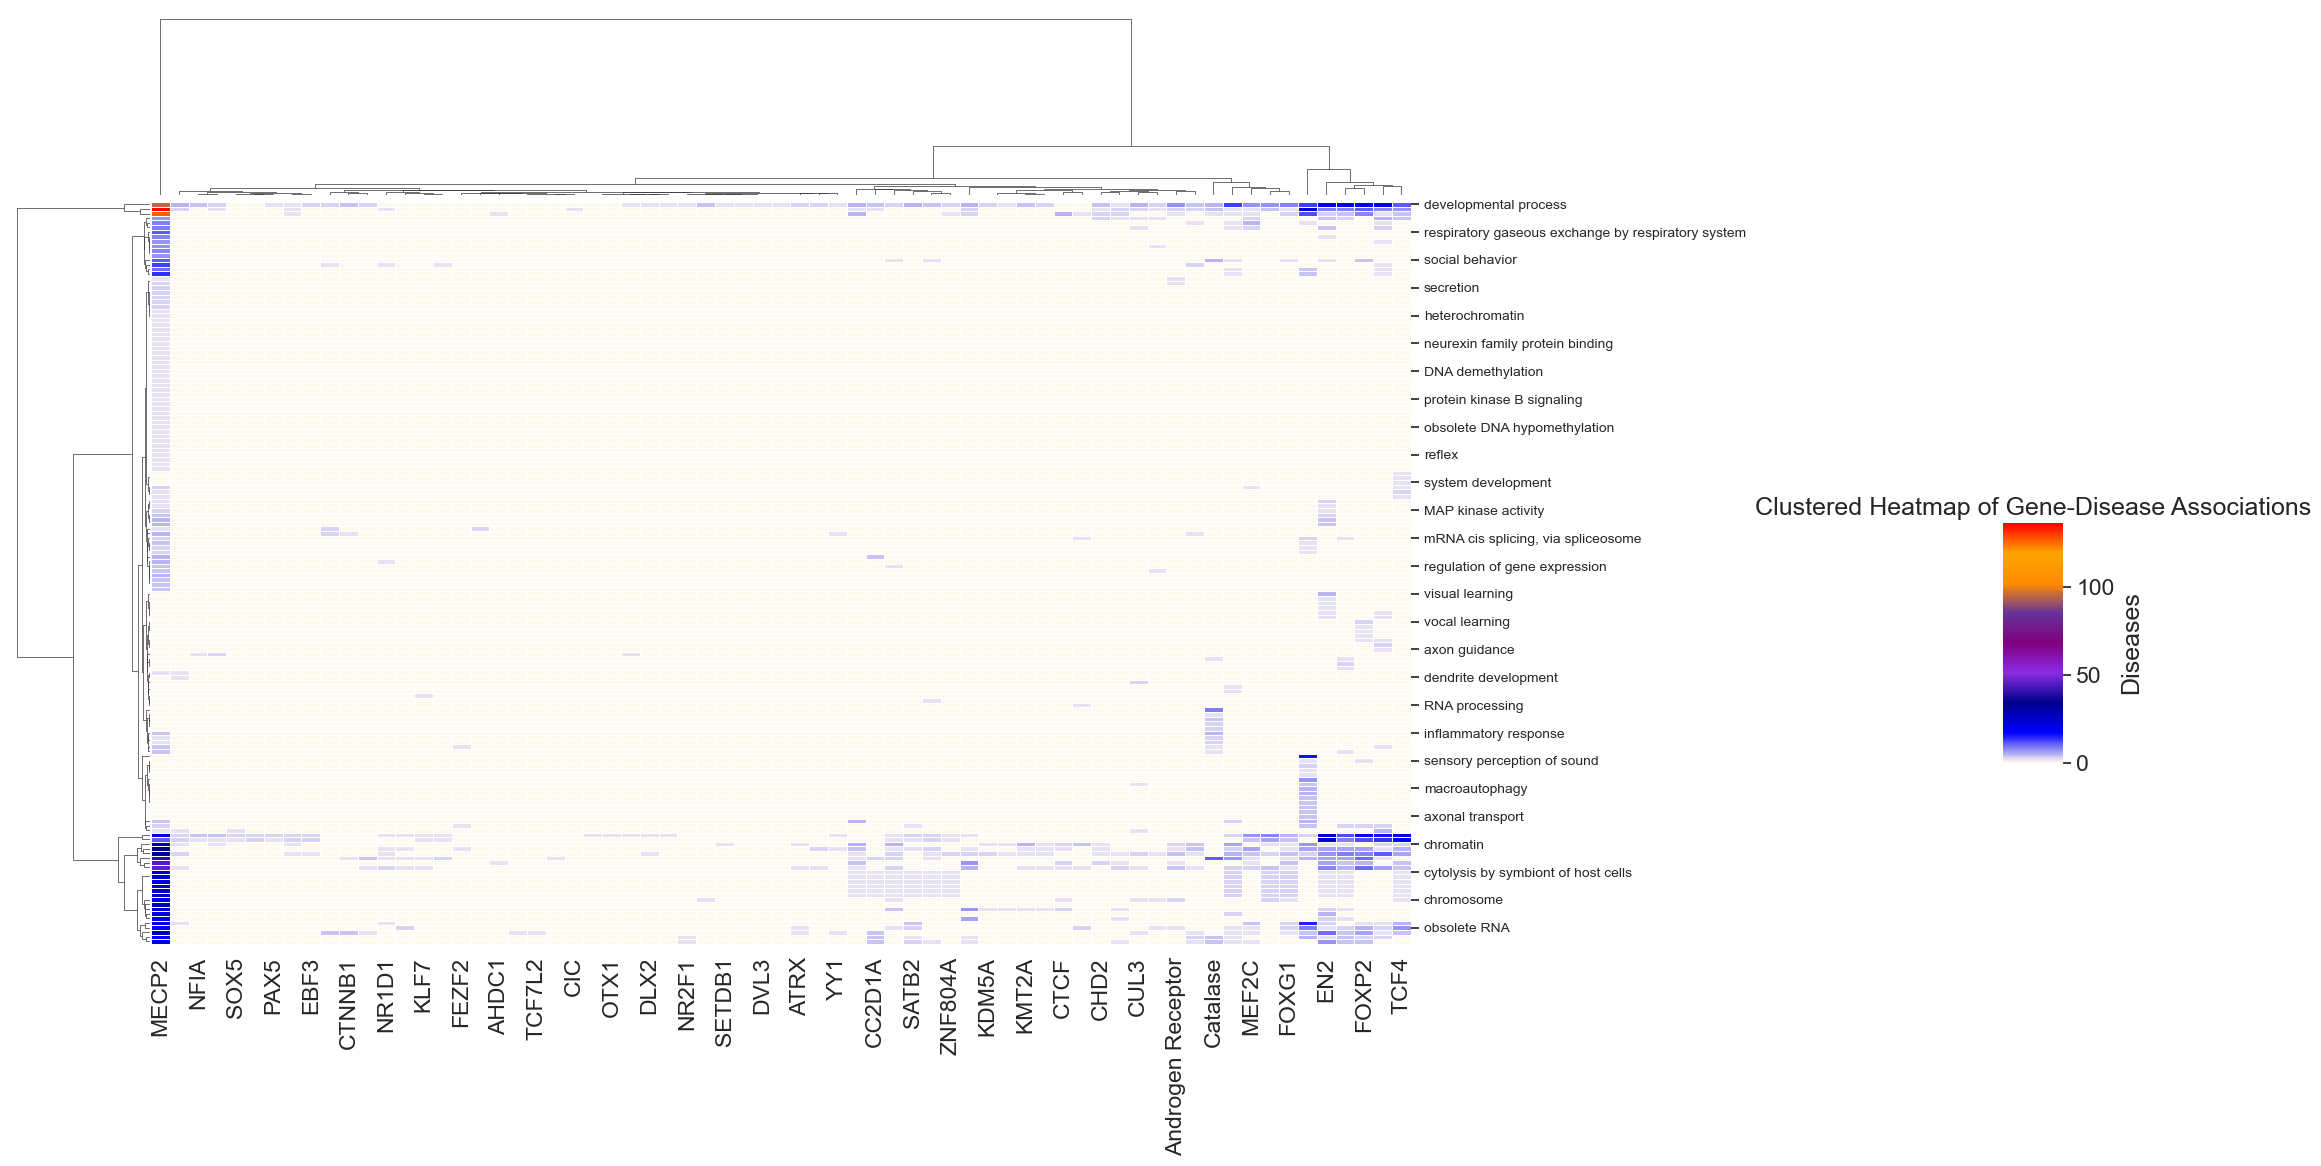

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

ontology_Gene_df = pd.DataFrame(ontology_Gene)
ontology_Gene_df.fillna(0, inplace=True)

cmap_list = [
    (0, "floralwhite"),
    (0.125, "blue"),
    (0.25, "darkblue"),
    (0.375, "blueviolet"),
    (0.5, "purple"),
    (0.625, "rebeccapurple"),
    (0.75, "darkorange"),
    (0.875, "orange"),
    (1, "red"),
]

cmap_custom = LinearSegmentedColormap.from_list("custom", cmap_list)

g = sns.clustermap(
    ontology_Gene_df,
    cmap=cmap_custom,
    linewidths=0.5,
    annot=False,
    cbar=True,
    figsize=(20,12),
    norm=plt.Normalize(vmin=0, vmax=np.max(ontology_Gene_df.values)),
    dendrogram_ratio=(.1, .2),
    cbar_pos=(1.01, .35, .03, .2),
    method='ward'
)

# Adjust the y-axis labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10)
g.ax_heatmap.yaxis.set_label_coords(-0.15, 0.5)

plt.xlabel("Genes")
plt.ylabel("Diseases")
plt.title("Clustered Heatmap of Gene-Disease Associations")
plt.show()
